In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import numpy as np
import os
import pickle
import pandas as pd
import time
import getpass
import psutil
import scipy.fftpack
from scipy import signal
import sys
import gc
import pandas as pd
import fnmatch
import shutil
import tables as tb

from scipy import stats

from ipywidgets import interact

import seaborn as sns


import imaging_behavior as ib
import imaging_behavior.io.manifest as manifest
import imaging_behavior.plotting.plotting_functions as pf
import imaging_behavior.plotting.standard_plots as sp
import imaging_behavior.plotting.utilities as pu
from imaging_behavior.core.slicer import BinarySlicer
from imaging_behavior.io import importRawJCam
import imaging_behavior.core.utilities as ut


%load_ext autoreload
%autoreload 2

# %matplotlib inline
%matplotlib notebook

## Some function definitions

In [2]:
def reformat_stimulus_ID(df_in):
    '''replace None entries with 'catch' to make sorting easier'''
    for index in df_in.index:
        if pd.isnull(df_in.loc[index].stimulus_id):
            df_in.loc[index,'stimulus_id'] = 'catch'
    
    return df_in

In [3]:
def get_local_event_times(df_in,event_type):
    # turn lick frames into lick times
    event_times = []
    for idx in df_in.index:
        event_times.append(df_in.loc[idx][event_type] - df_in.loc[idx].starttime)

    return event_times

## Define some variables

In [4]:
mice = ['M252300','M241393','M246779','M242594','M246789','M241394']
basepath = '//aibsdata/neuralcoding/Behavior/Data'
# basepath = '/Users/dougo/Dropbox/PythonCode/Behavior/AssociativeLearningPilot'
stimuli = ['CoxImage1.png', 'CoxImage2.png', 'catch']
span_colors = ['green','red',None]
line_colors = ['green','red','black']

## Build a dataframe containing all mice

In [5]:
df = pd.DataFrame()
all_data = {}
pb = ut.progress(len(mice))
for mouse in mice:
    all_data[mouse] = {}
    files = np.sort(os.listdir(os.path.join(basepath,mouse,'output')))
    
    for ii,filename in enumerate(files):
        data = pd.read_pickle(os.path.join(basepath,mouse,'output',filename))
        dft = pd.DataFrame(data['triallog'])
        all_data[mouse][data['startdatetime']] = data
        dft['mouse_id'] = data['mouseid']
        dft['startdatetime'] = data['startdatetime']
        dft = reformat_stimulus_ID(dft)
        
        df = pd.concat((df,dft),ignore_index=True)
    pb.update()
        
#         stim_prob
        

In [6]:
mice

['M252300', 'M241393', 'M246779', 'M242594', 'M246789', 'M241394']

In [7]:
stim_probs = {}
for mouse in mice: 
    for date in all_data[mouse].keys():
        stim_probs[mouse] = all_data[mouse][date]['stimulus_probability']

## Make lick rasters and histograms for each mouse

In [8]:
def get_metrics(df_in):
    lick_times = get_local_event_times(df_in,'lick_times')
    first_lick = []
    for licks_in_trial in lick_times:
        first_lick_post_stim = licks_in_trial[licks_in_trial>2]
        if len(first_lick_post_stim)>0:
            first_lick.append(first_lick_post_stim[0])

    ntrials = len(df_in)
    
    all_licks = ut.flatten_array(lick_times)

    prestim_licks = all_licks[np.logical_and(all_licks>=1,all_licks<2)]

    poststim_licks = all_licks[np.logical_and(all_licks>=2,all_licks<3)]

    
    return len(prestim_licks)/(1.0*ntrials),len(poststim_licks)/(1.0*ntrials),np.mean(first_lick)

In [9]:
all_data[mice[0]].keys()

['2016-08-04 09:34:55.678000',
 '2016-08-02 14:14:15.248000',
 '2016-08-09 13:59:58.625000',
 '2016-07-26 09:20:42.420000',
 '2016-07-28 13:58:39.998000',
 '2016-07-25 14:43:36.453000',
 '2016-07-27 09:29:44.329000',
 '2016-08-05 12:20:46.696000',
 '2016-08-10 14:38:47.038000',
 '2016-08-08 12:50:28.639000',
 '2016-08-03 09:43:29.968000',
 '2016-08-11 09:53:58.475000',
 '2016-07-29 09:06:22.617000',
 '2016-08-01 10:02:07.220000']

In [10]:
np.sort(df.stimulus_id.unique())

array(['CoxImage1.png', 'CoxImage2.png', 'catch'], dtype=object)

In [19]:
mouse = 'M252300'
startdates =  df[(df.mouse_id == mouse)].startdatetime.unique()
print startdates[-1]
dft = df[(df.stimulus_id == 'CoxImage1.png') & (df.mouse_id == mouse) & (df.startdatetime==startdates[-1])]
dft.rewarded.unique()

2016-08-11 09:53:58.475000


array([True, False], dtype=object)

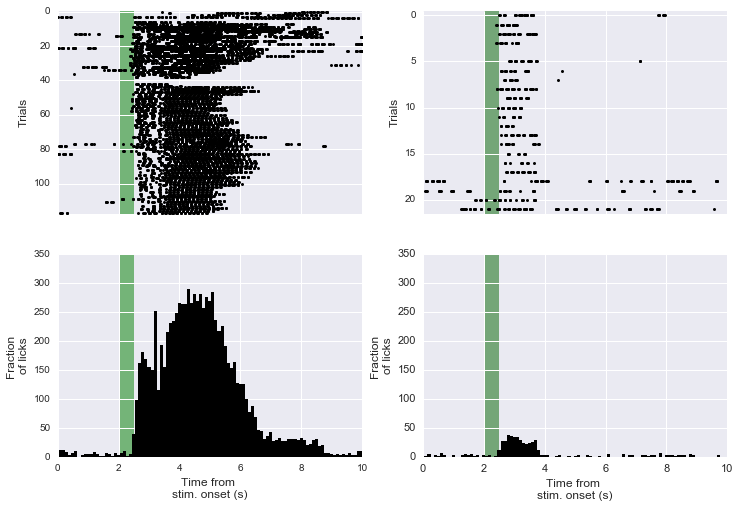

In [20]:
fig,ax=plt.subplots(2,2,figsize=(12,8))

for ii,rewarded in enumerate([True,False]):

    lick_times = get_local_event_times(dft[dft.rewarded == rewarded],'lick_times')            

    pf.plotLickRaster(lick_times,ax=ax[0,ii],splitLicksOnReward=False,
                                  plotPostRewardLicks=True,
                                  showXLabel=False,showYLabel=True,showYTicks=True,
                                  postlickcolor='blue',fontsize=12,stimulus_delay=2,
                                  leftlim=0,rightlim=10,
                                  span_color=span_colors[ii],span_width=0.5)

    #plot lick histogram
    pf.plotLickPSTH(lick_times,ax=ax[1,ii],splitLicksOnReward=False,
                    plotPostRewardLicks=True,
                    showXLabel=True,showYLabel=True,showYTicks=True,
                    normalize_y=False,ylim=350,
                    postlickcolor='blue',fontsize=12,stimulus_delay=2,
                    leftlim=0,rightlim=10,
                    span_color=span_colors[ii],span_width=0.5)
fig.savefig('f:/'+startdates[-1].split(" ")[0]+'.png')

In [21]:
startdates[-1].split(" ")[0]

'2016-08-11'

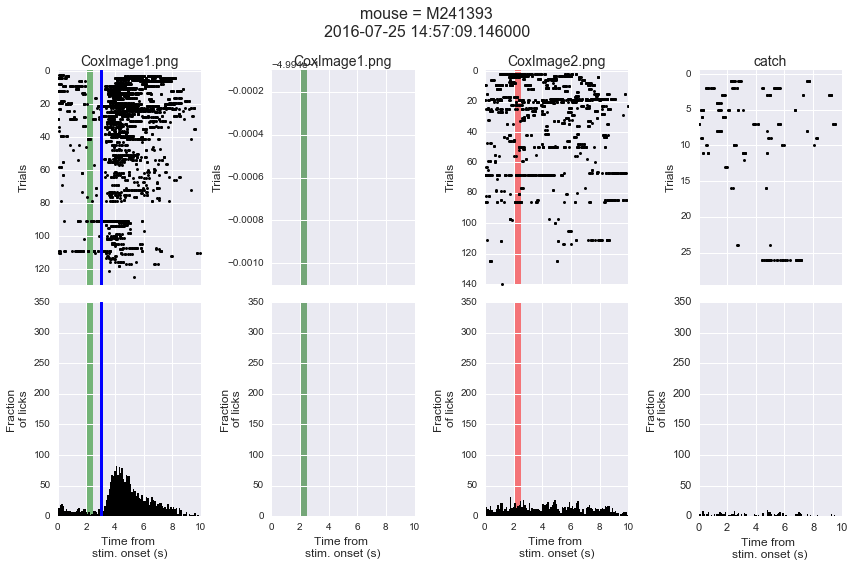

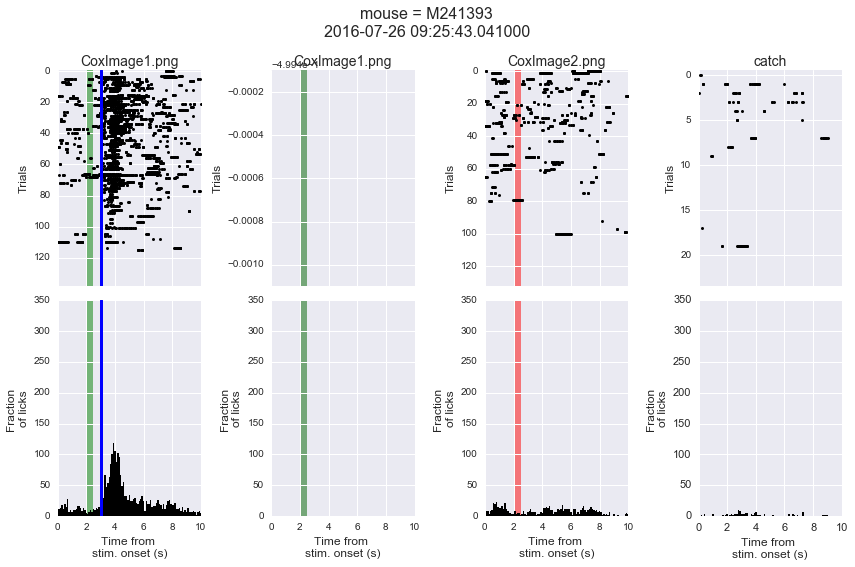

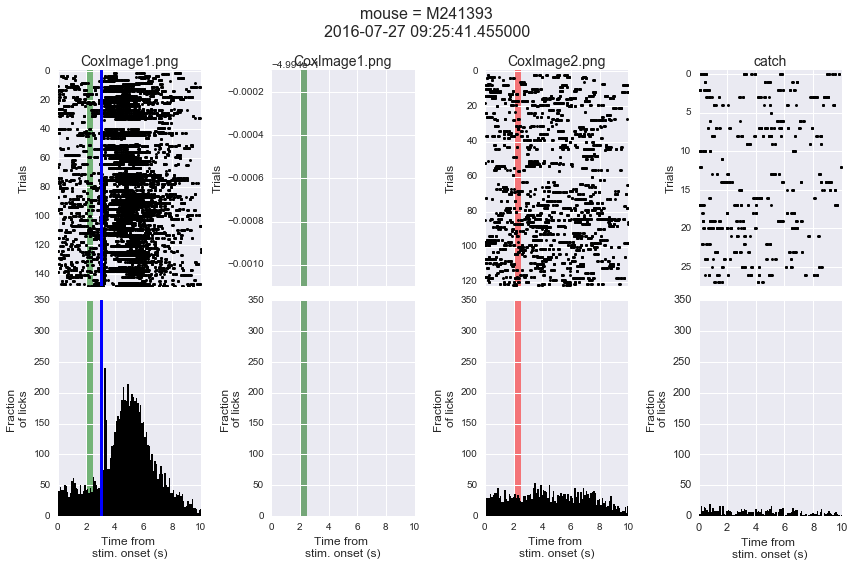

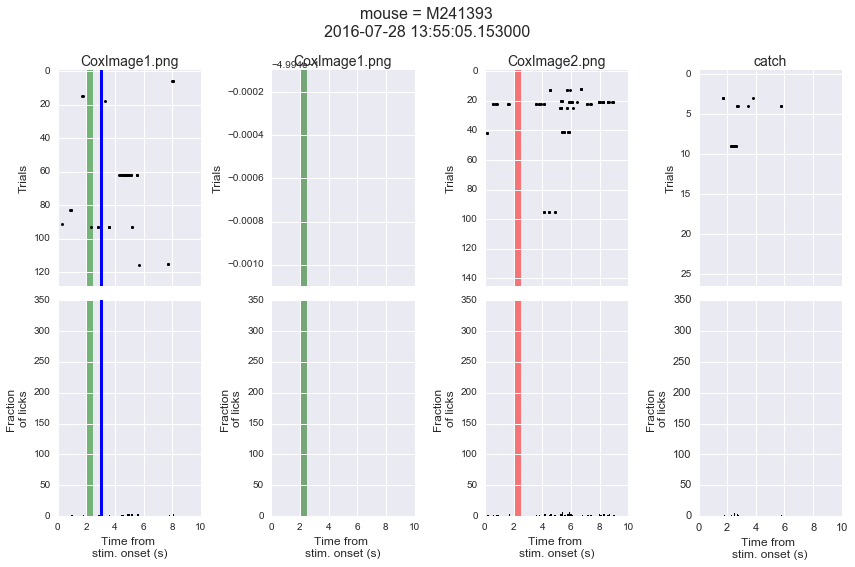

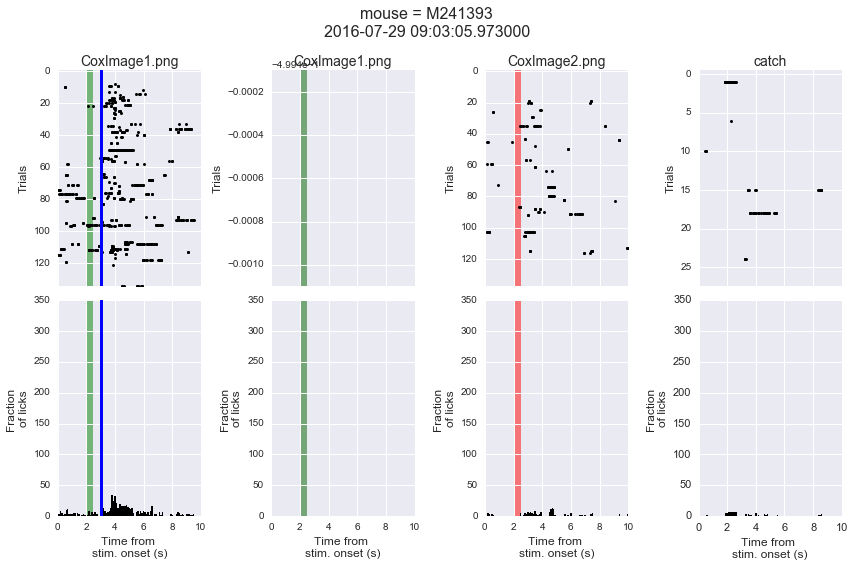

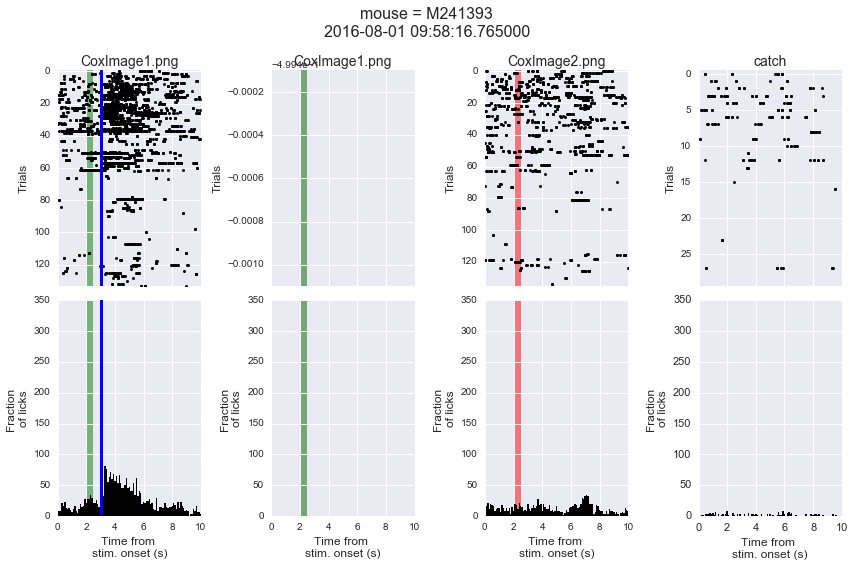

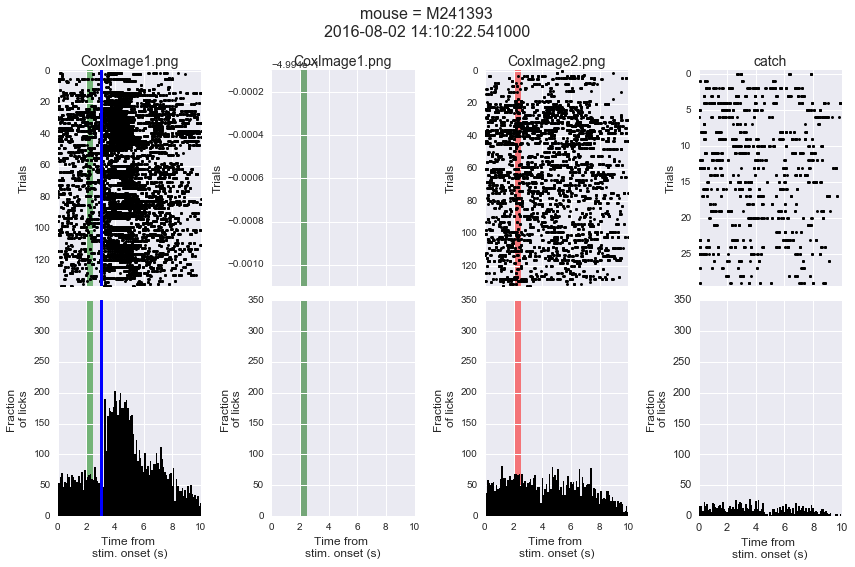

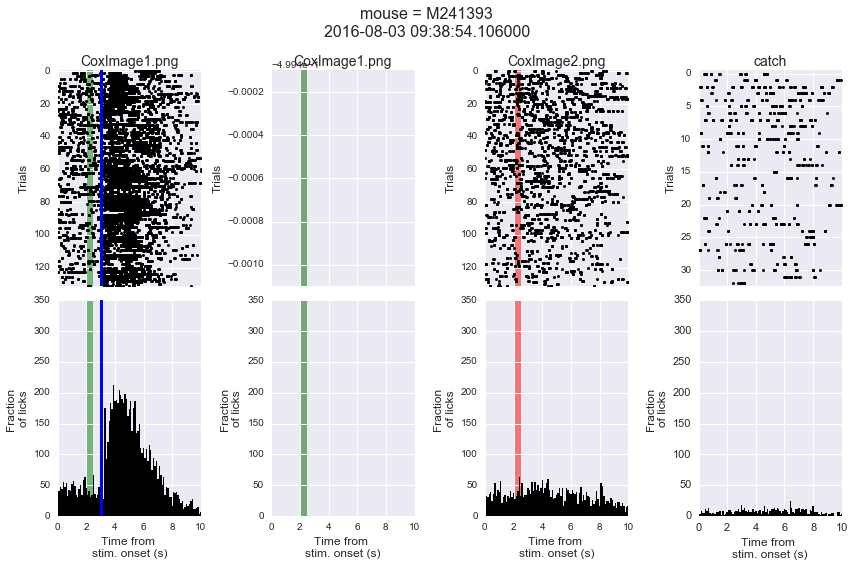

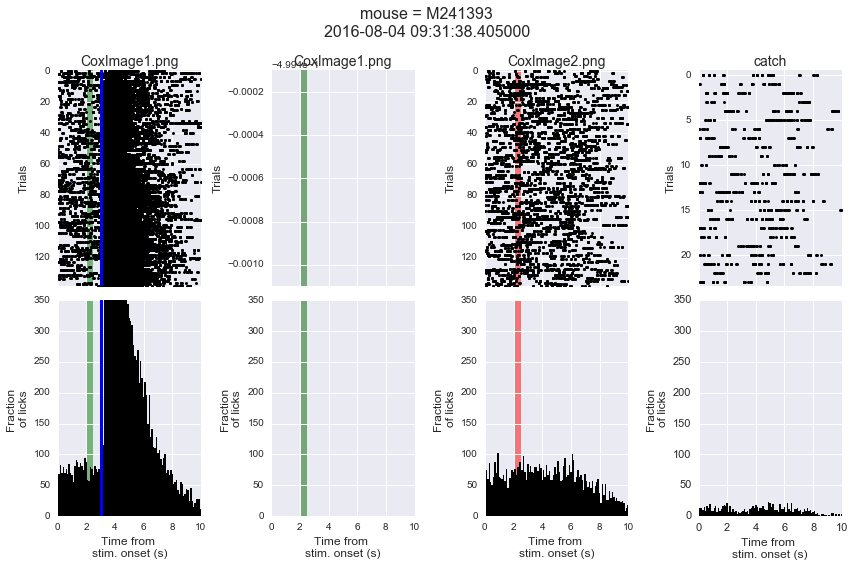

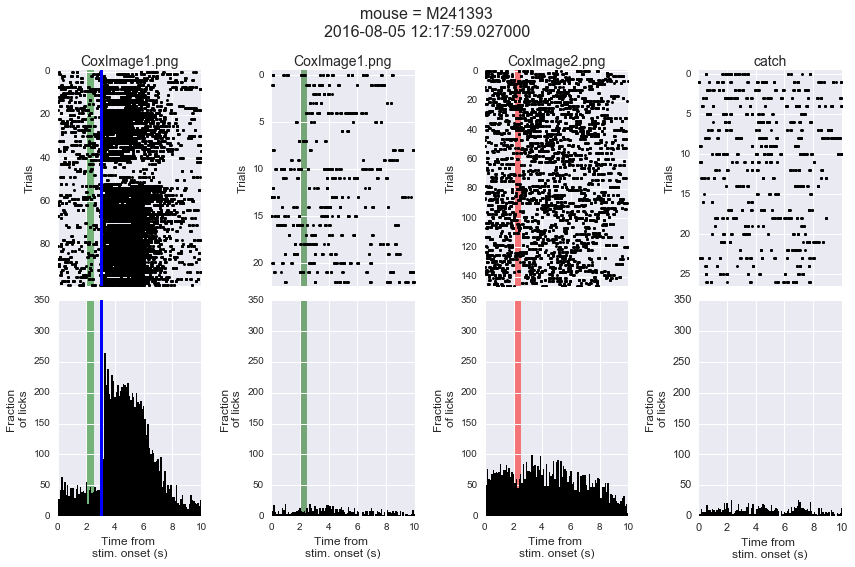

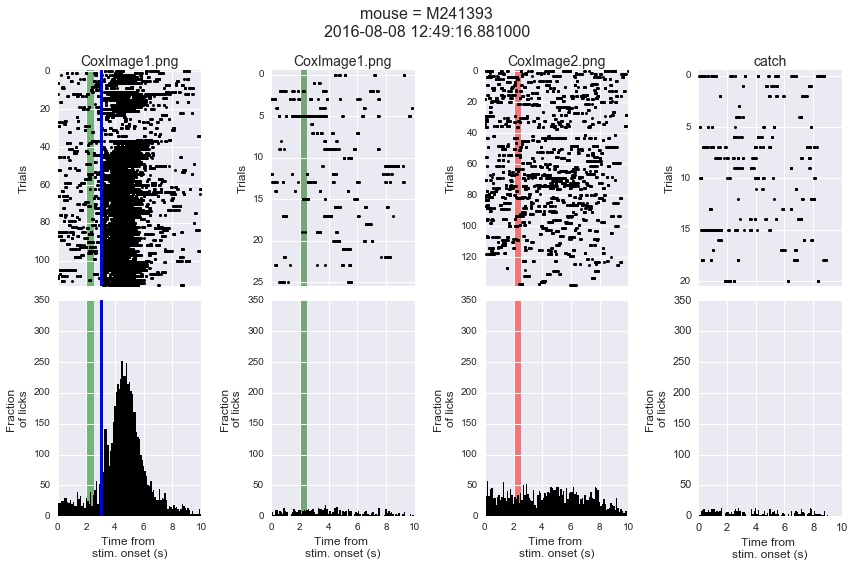

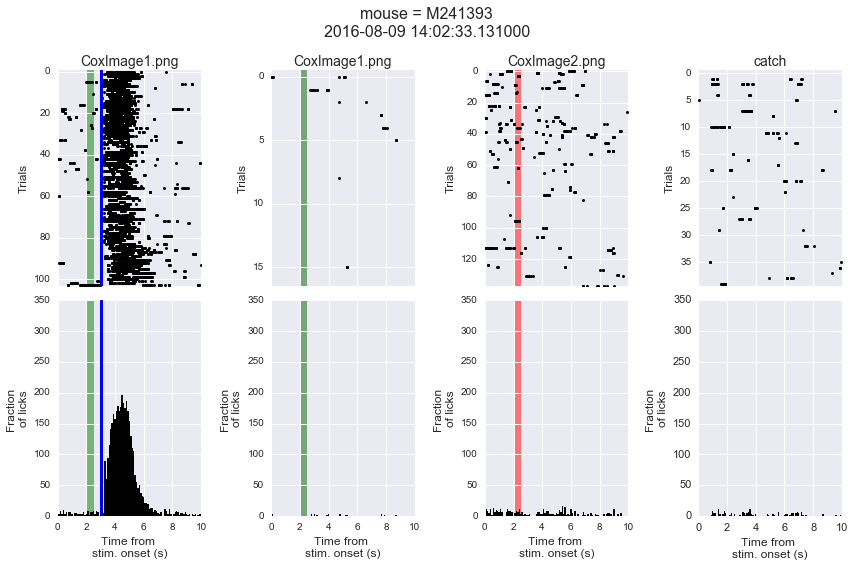

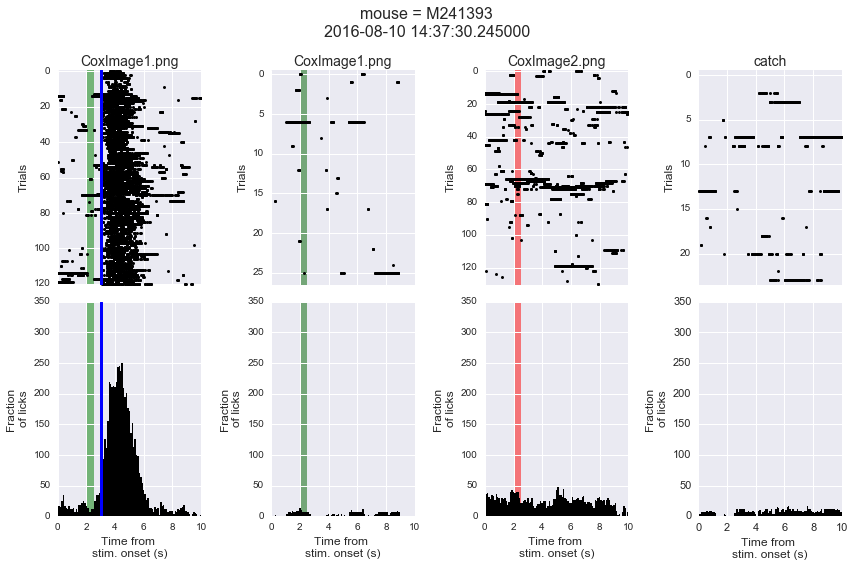

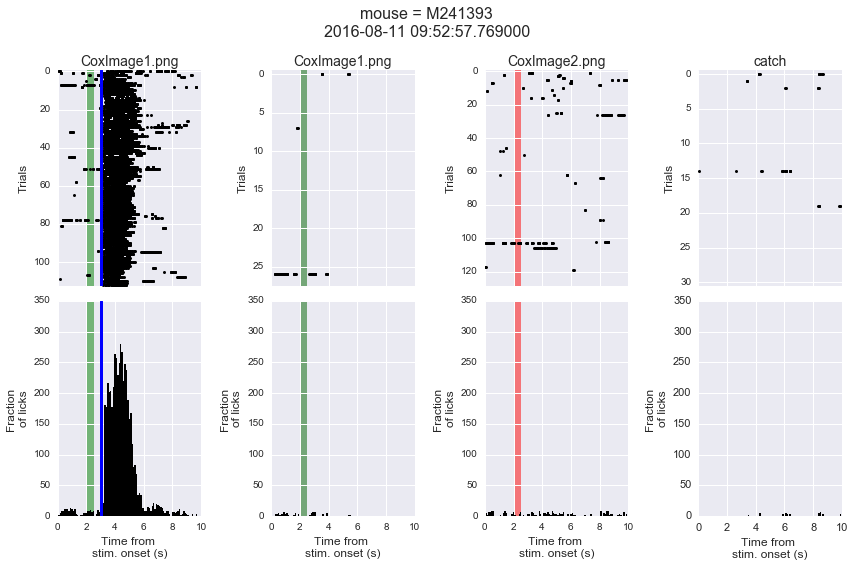

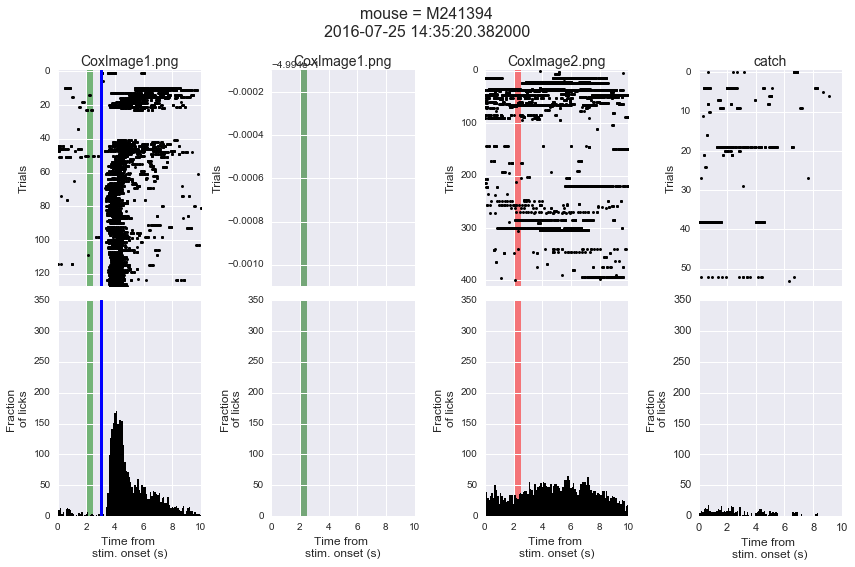

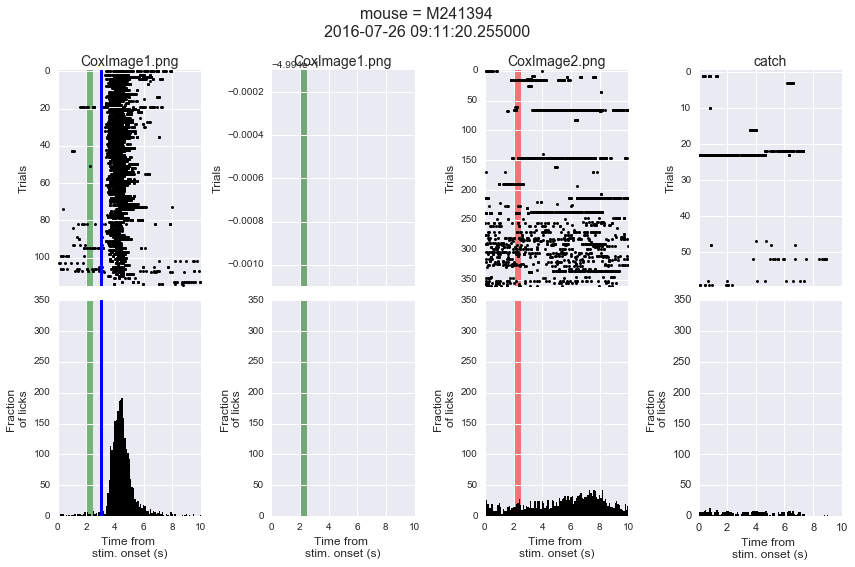

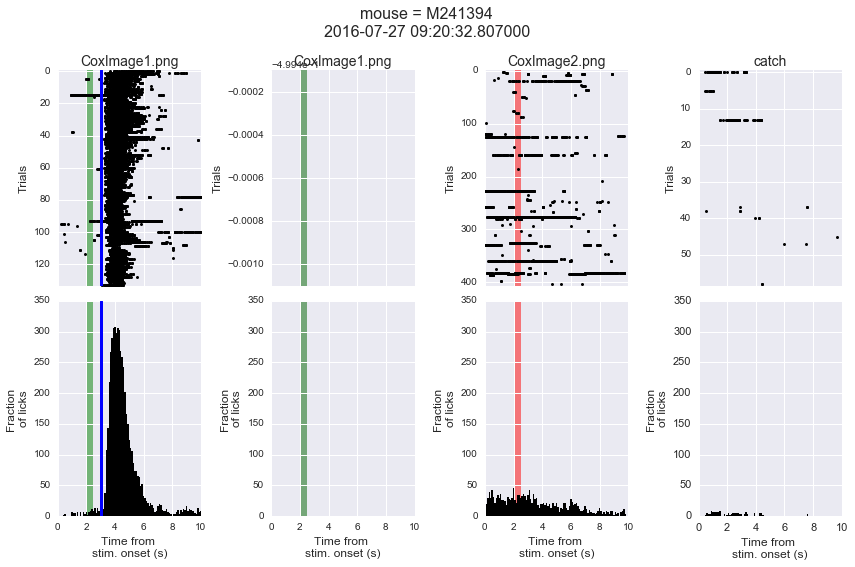

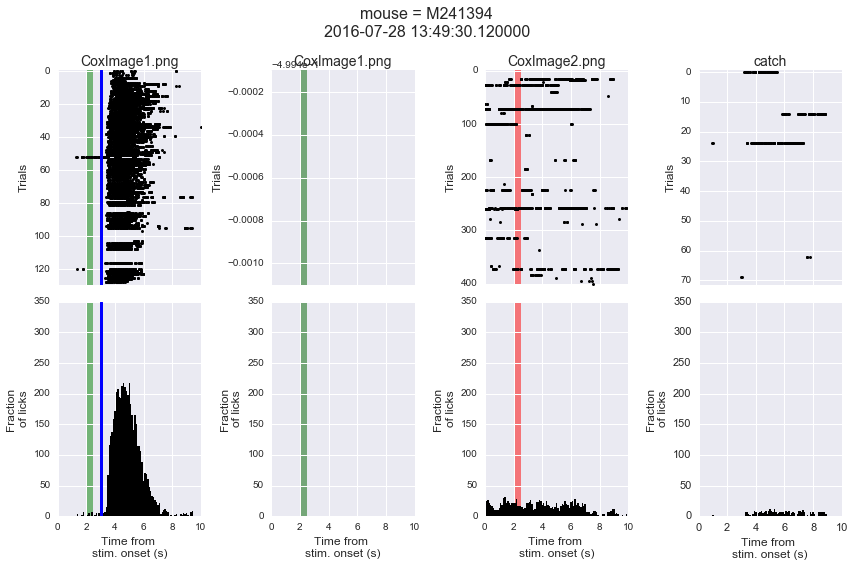

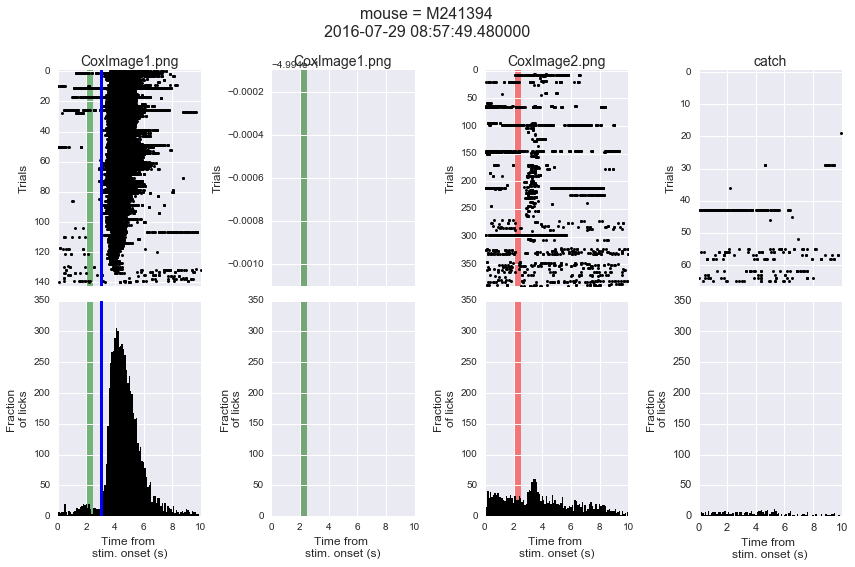

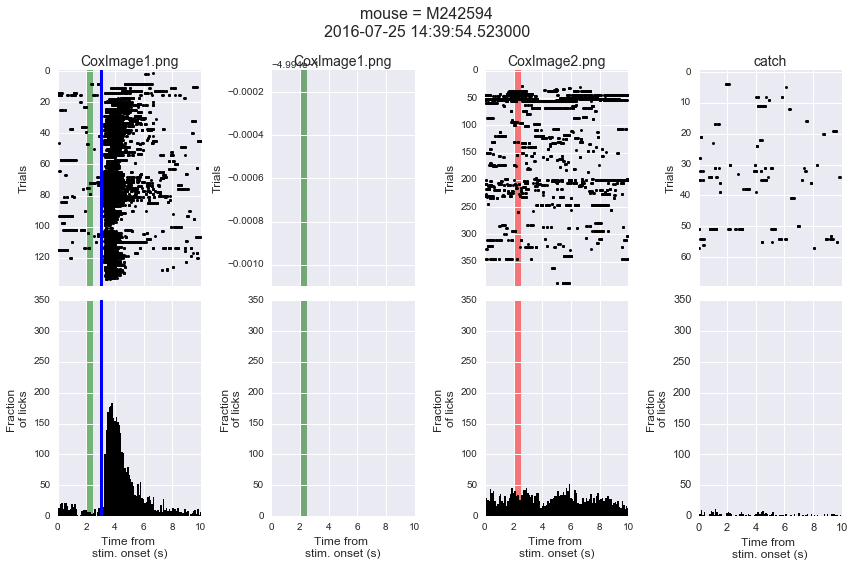

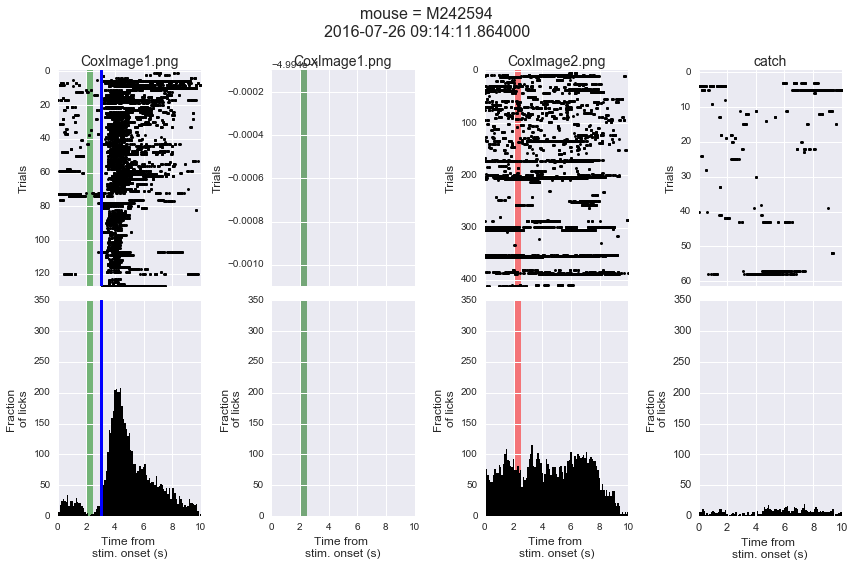

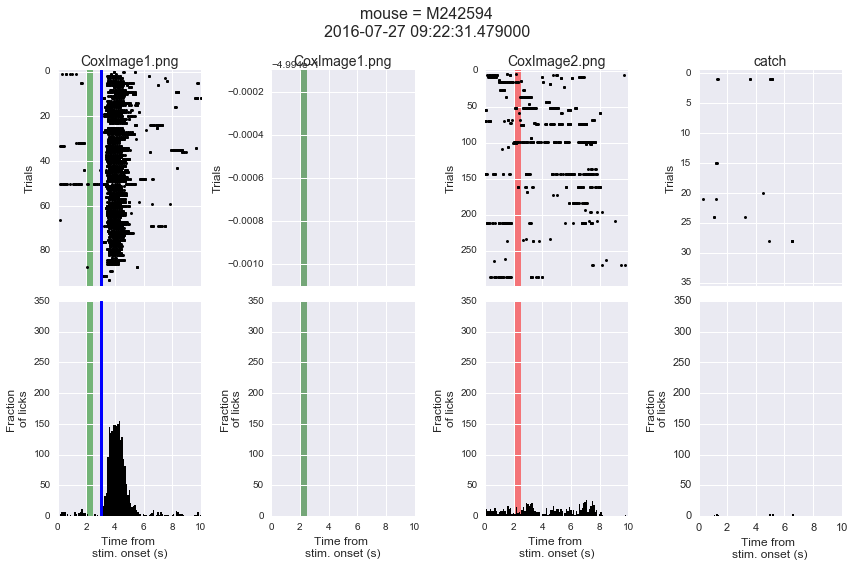

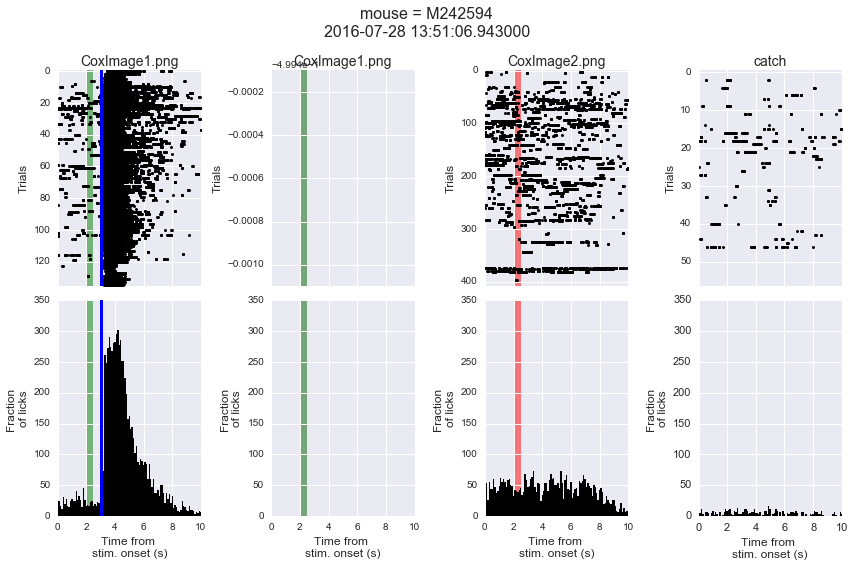

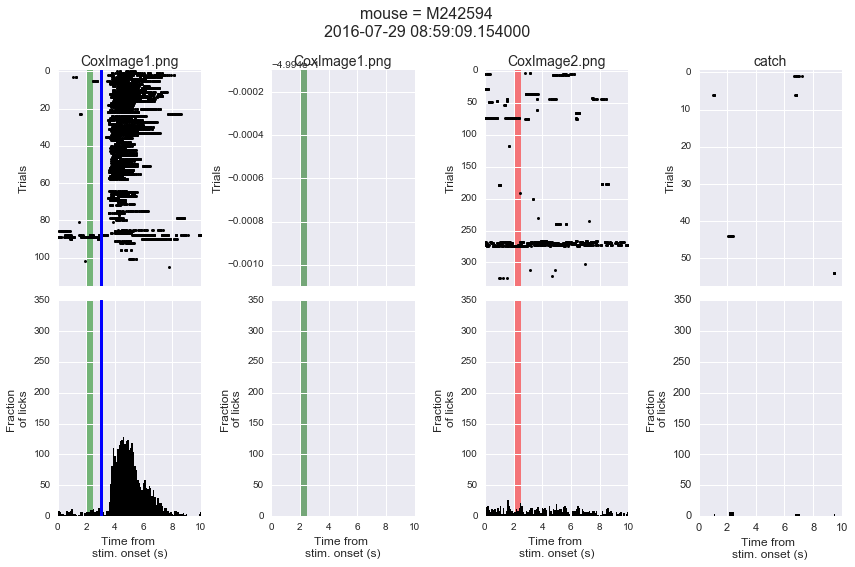

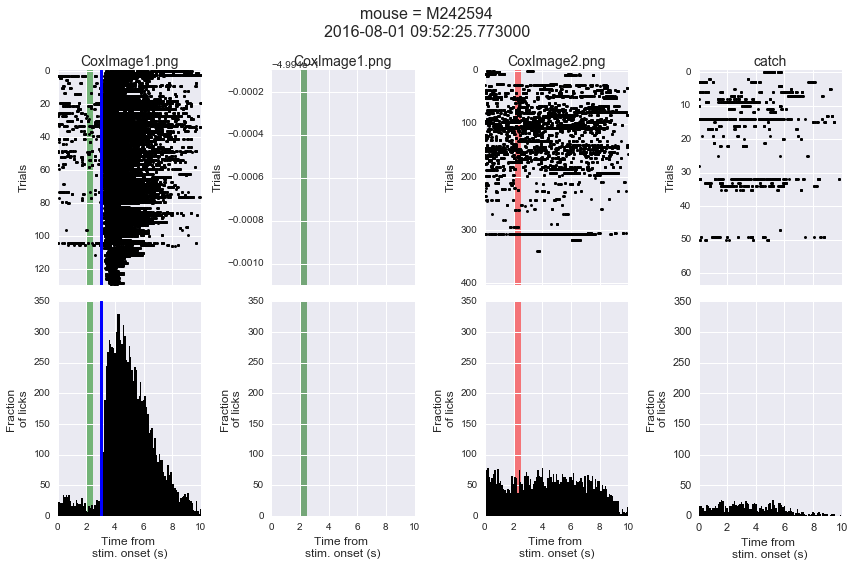

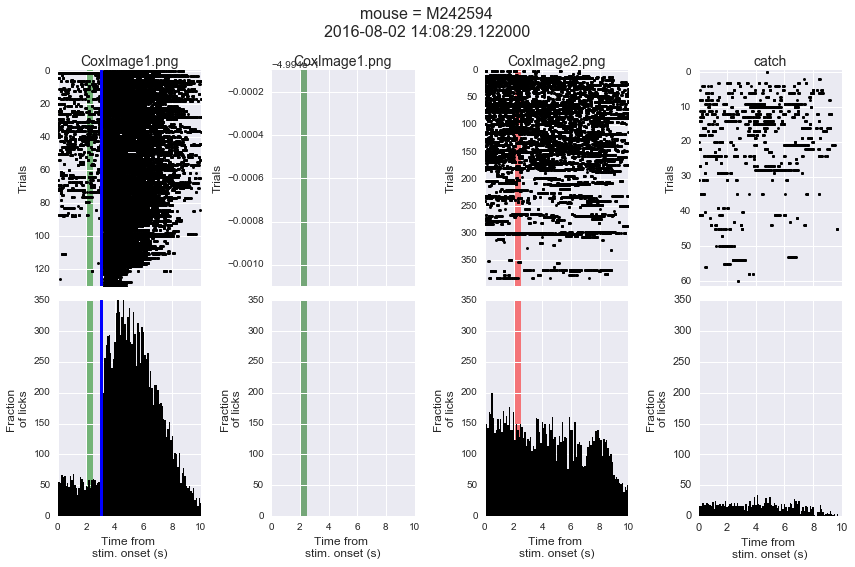

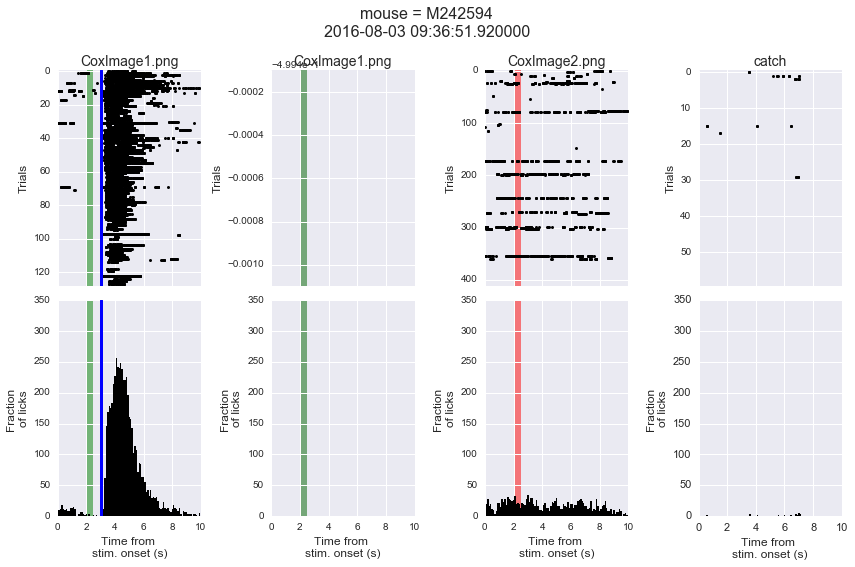

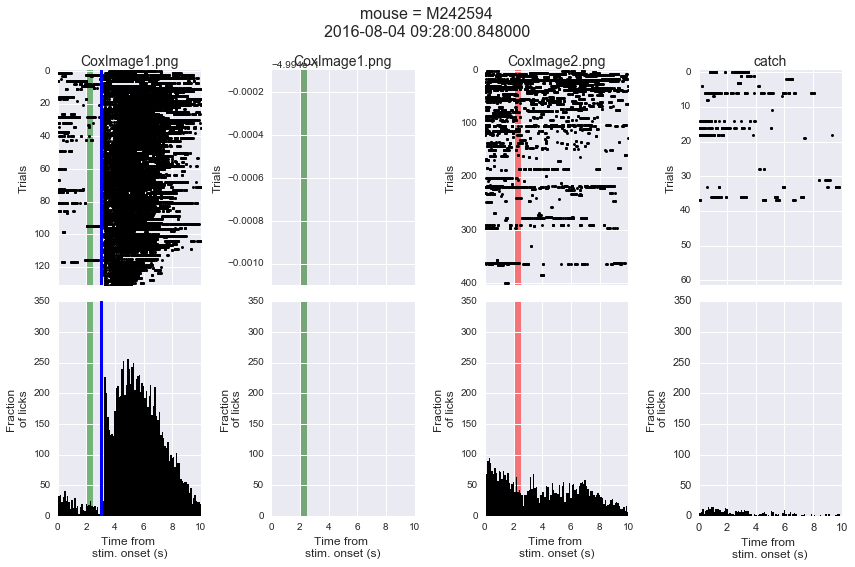

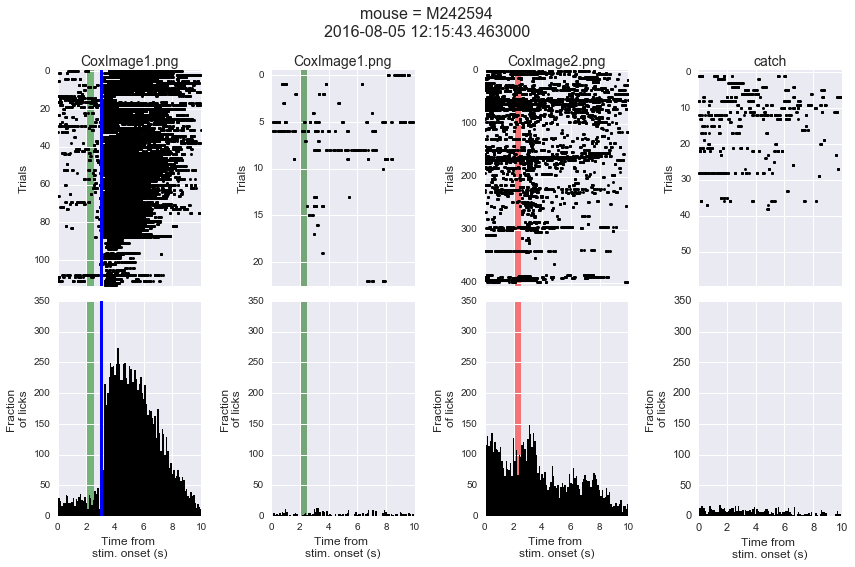

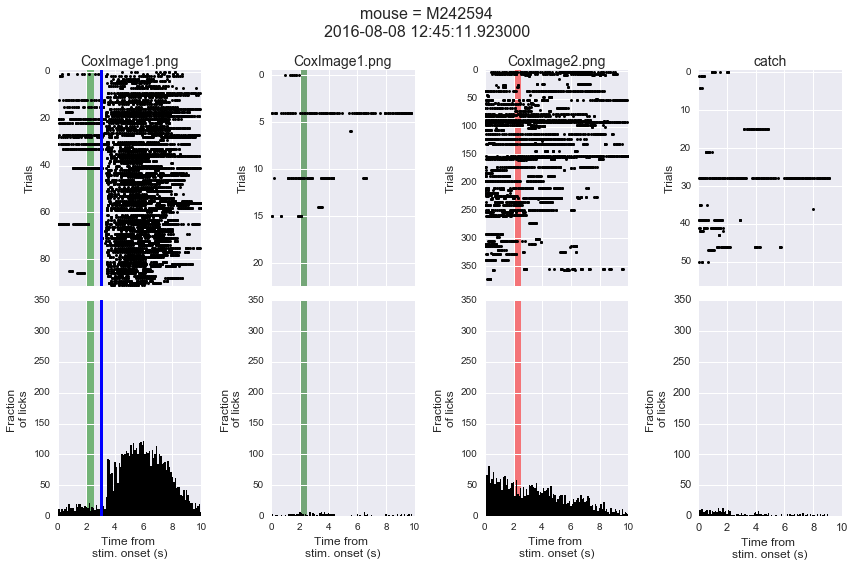

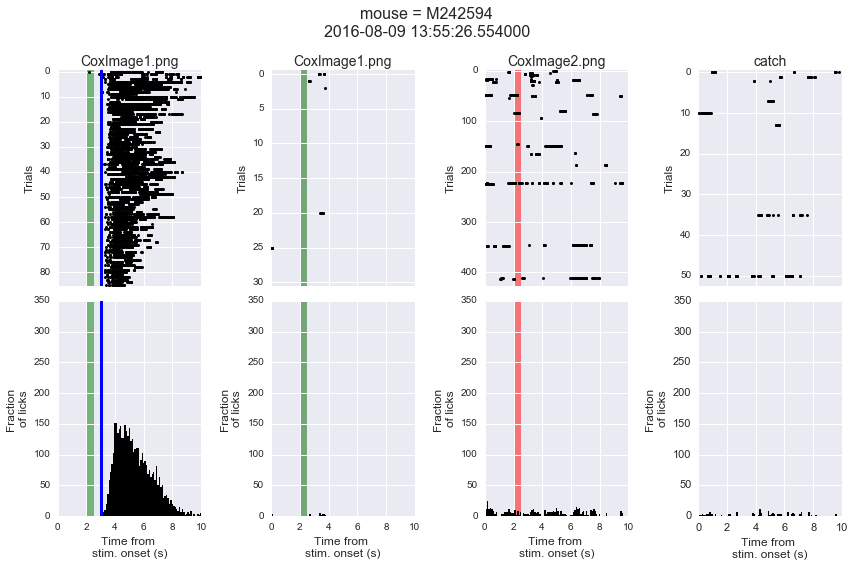

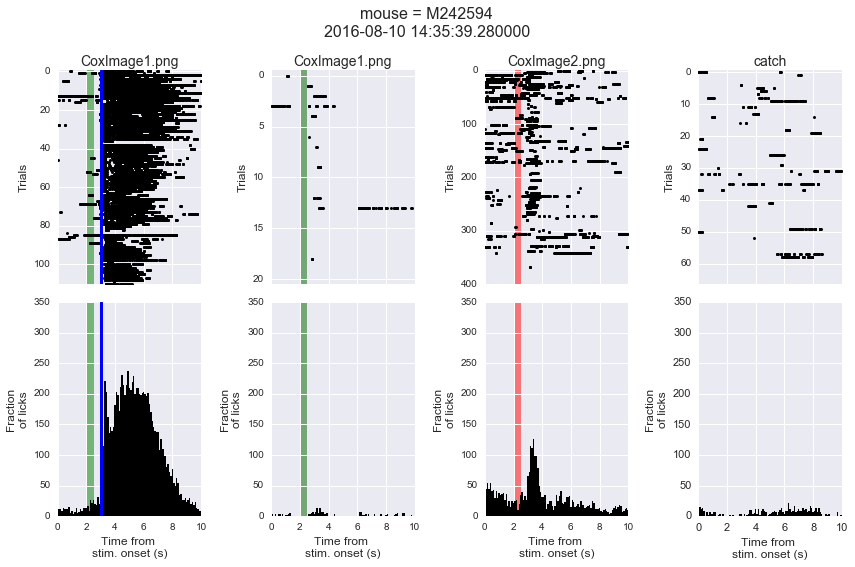

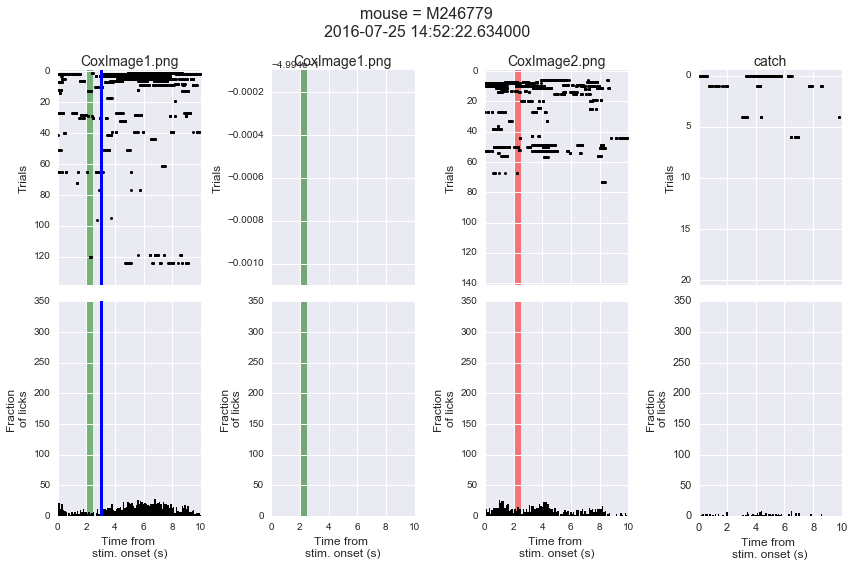

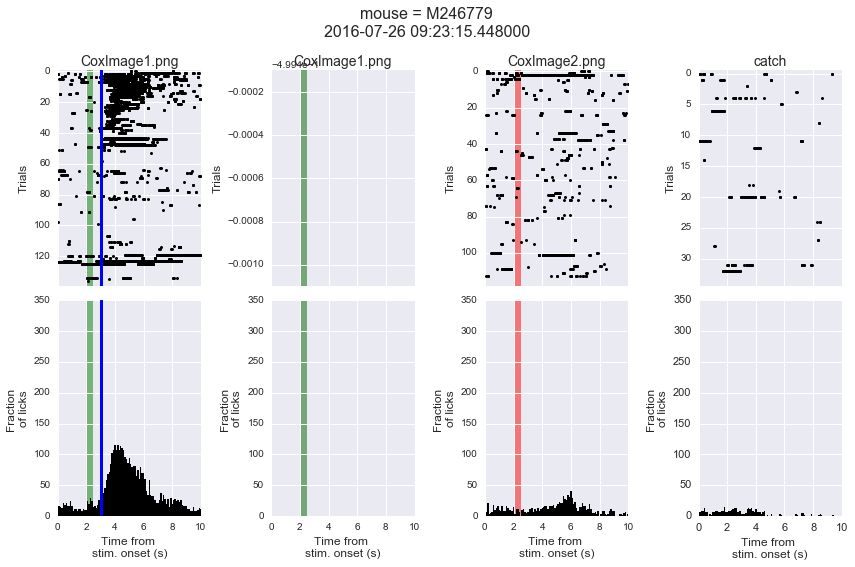

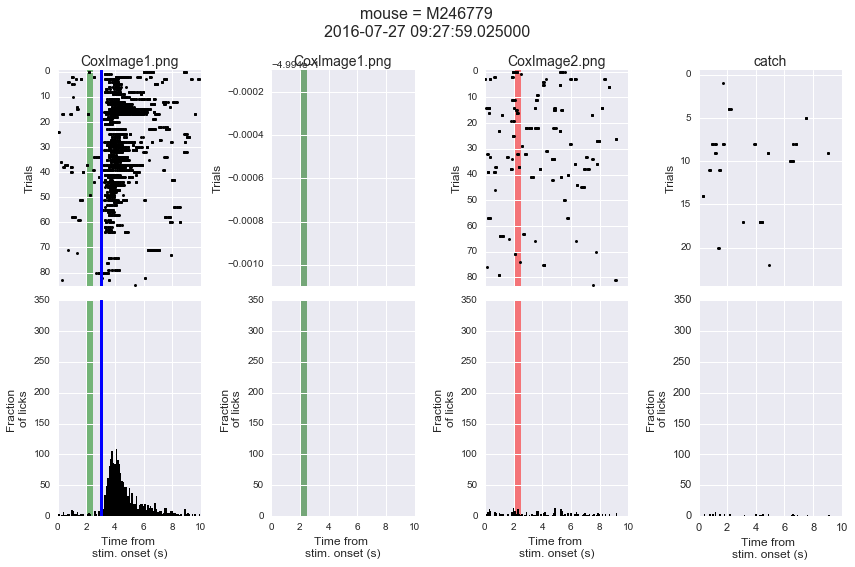

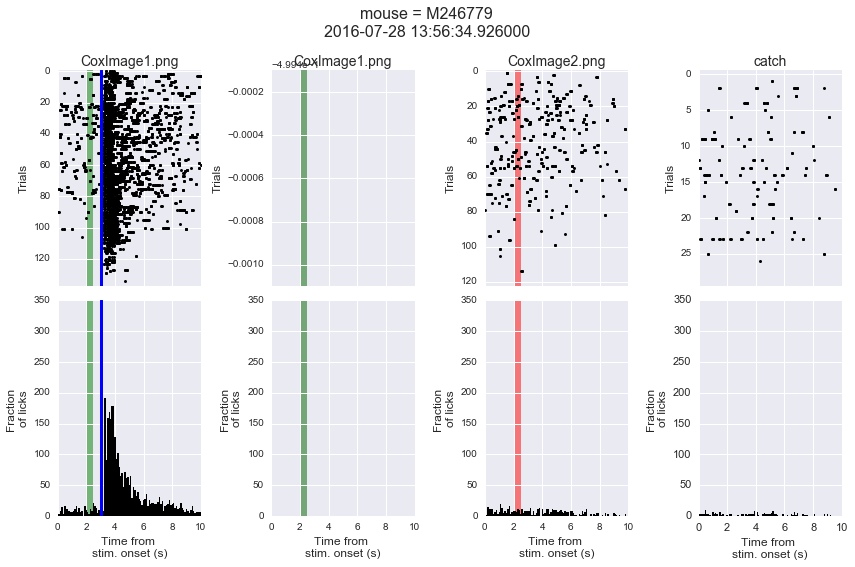

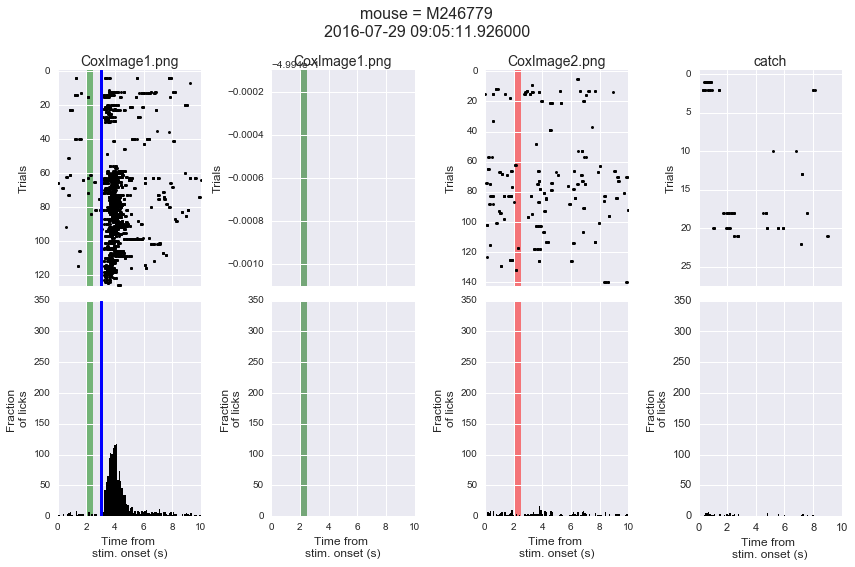

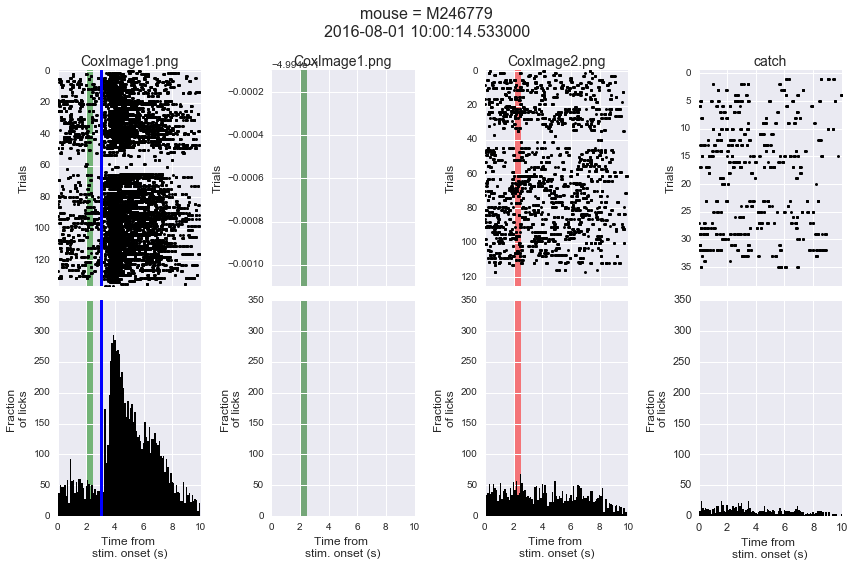

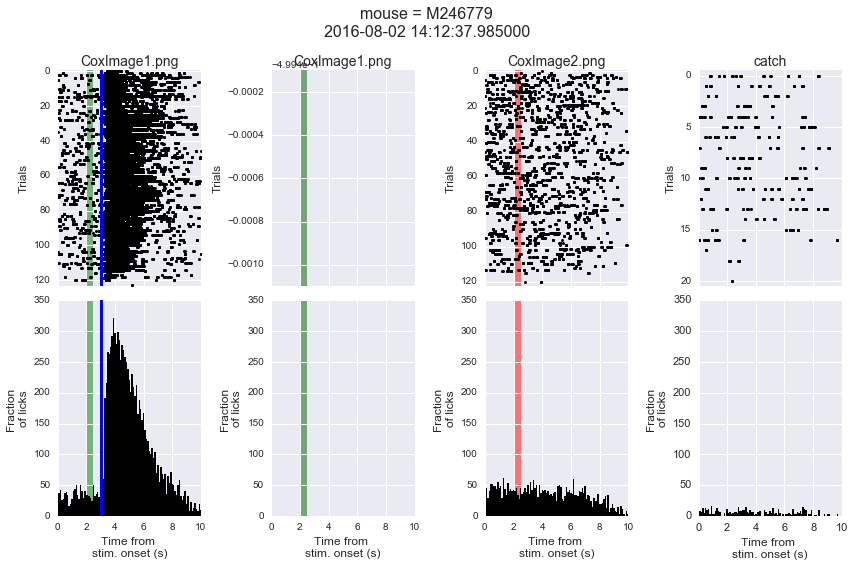

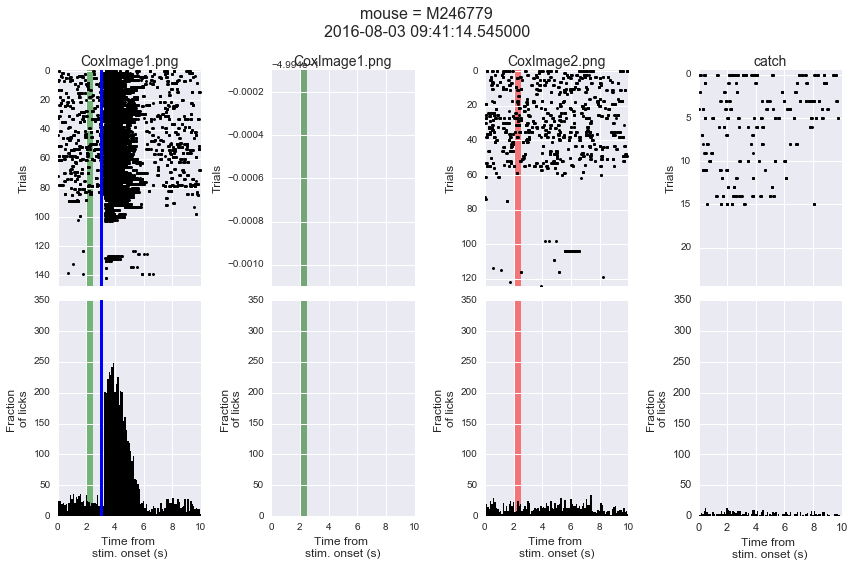

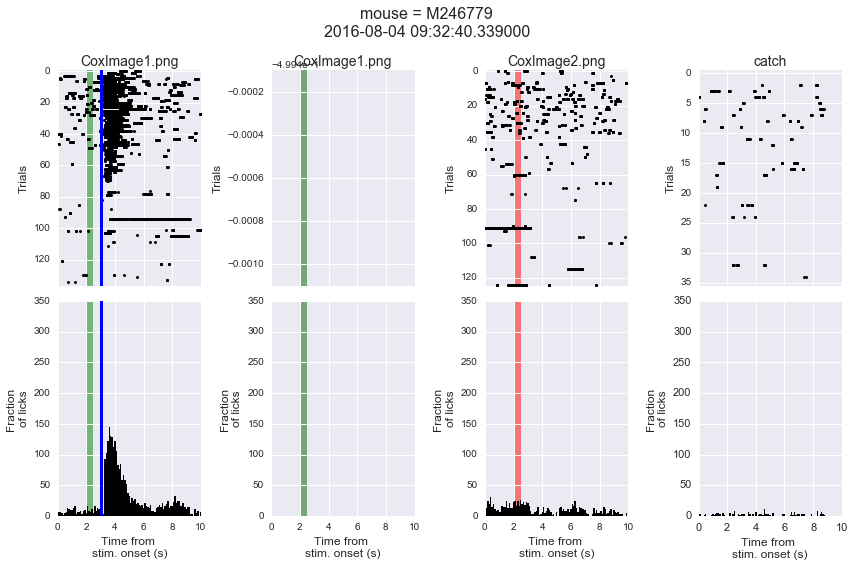

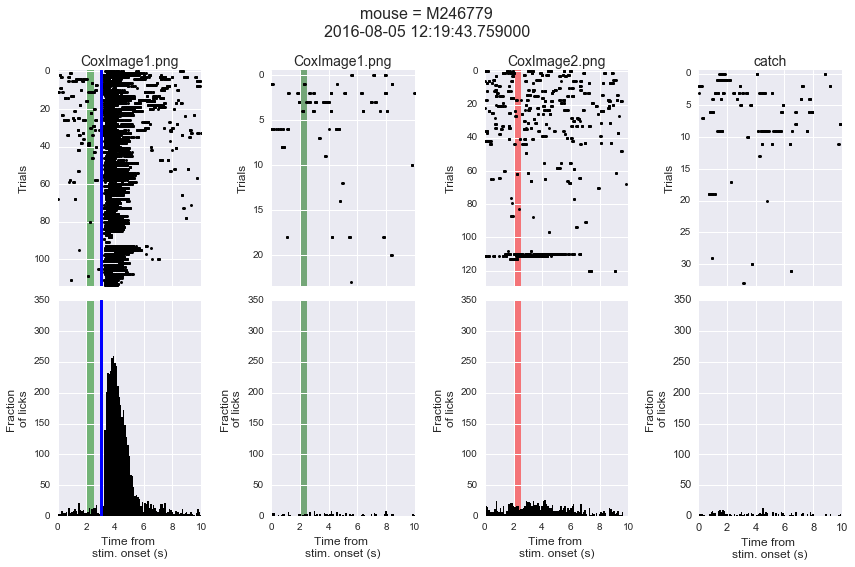

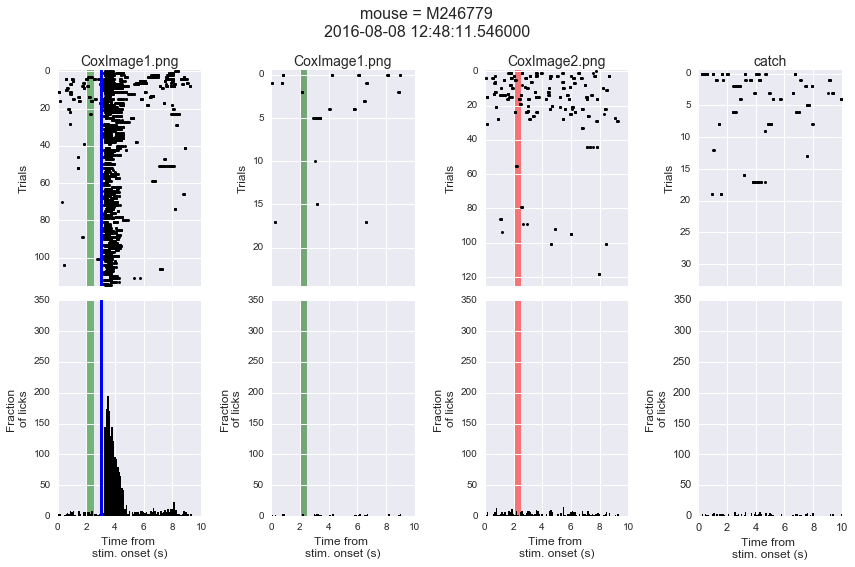

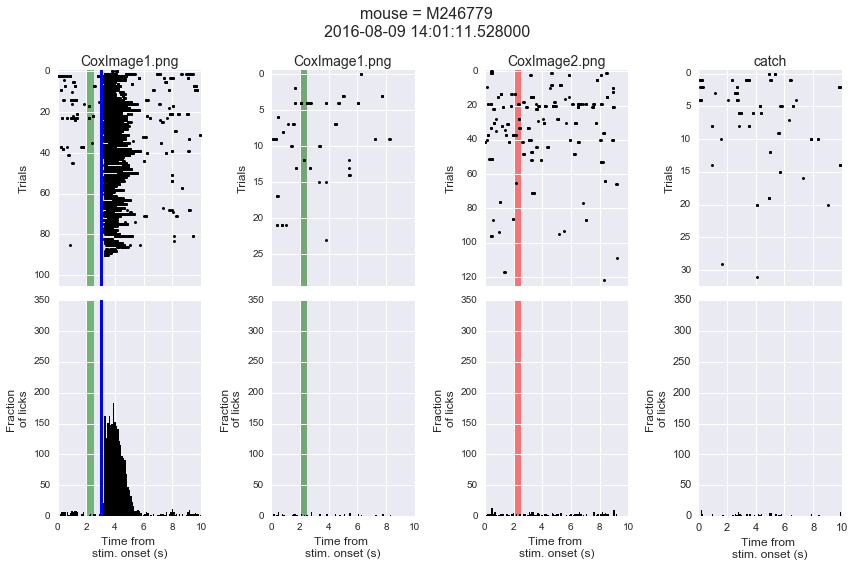

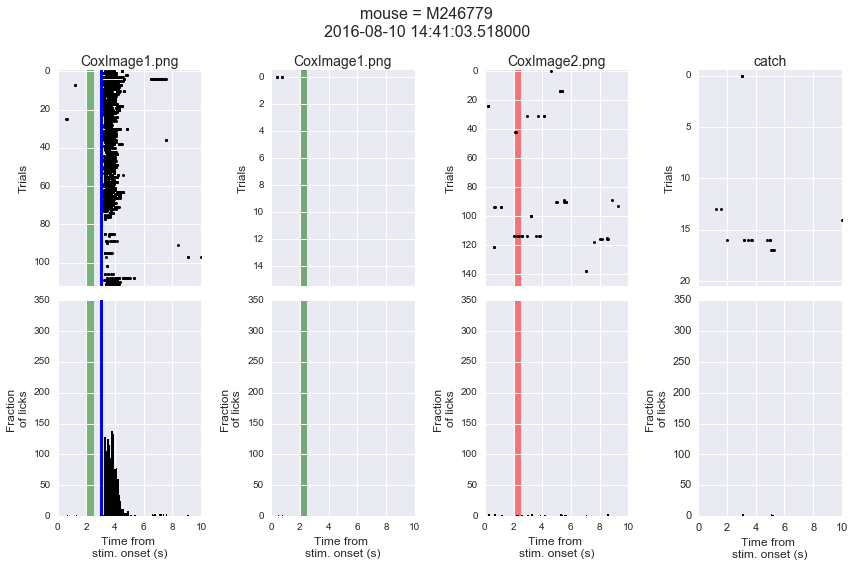

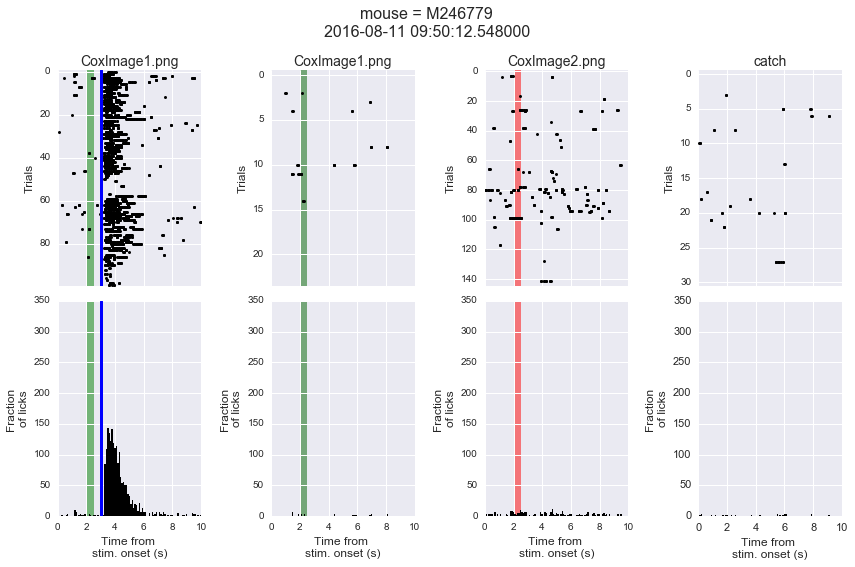

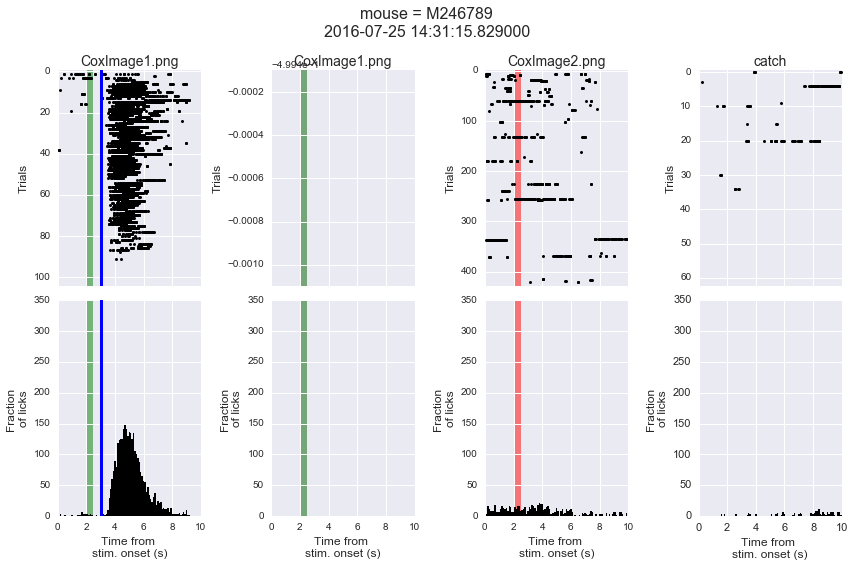

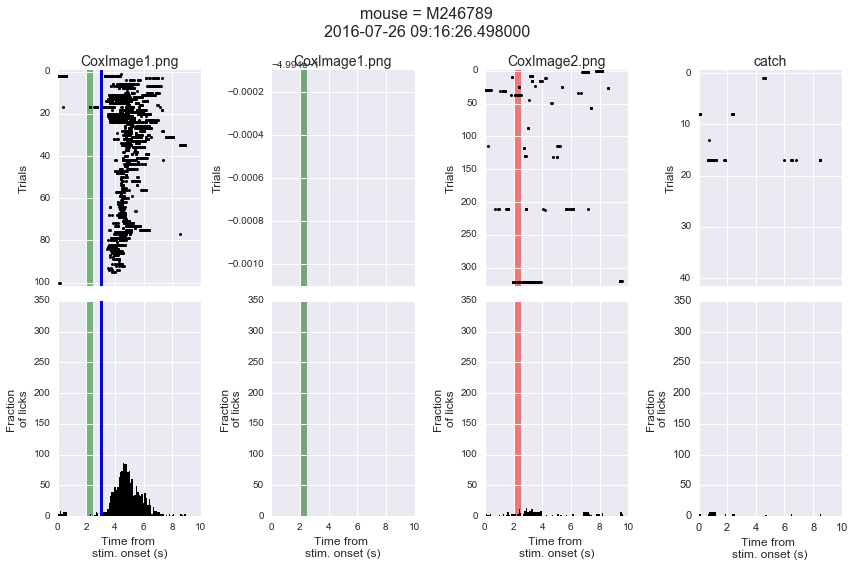

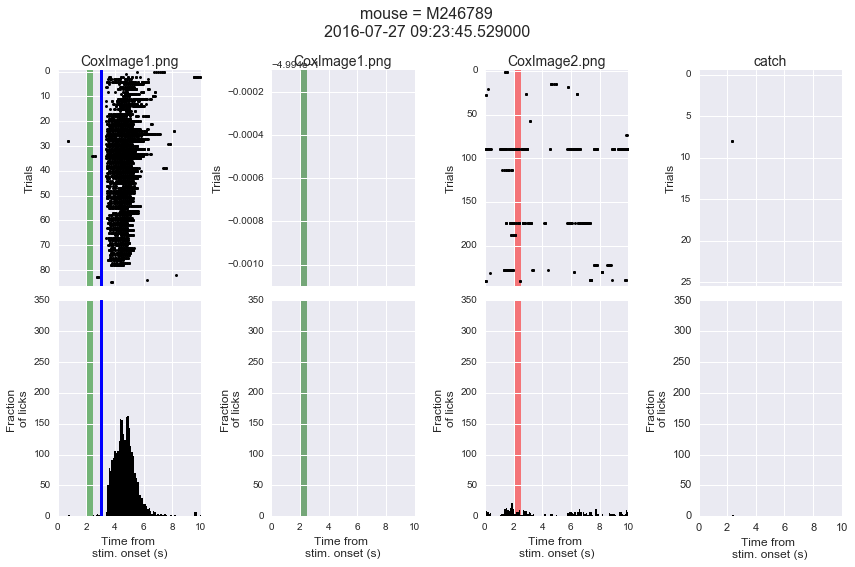

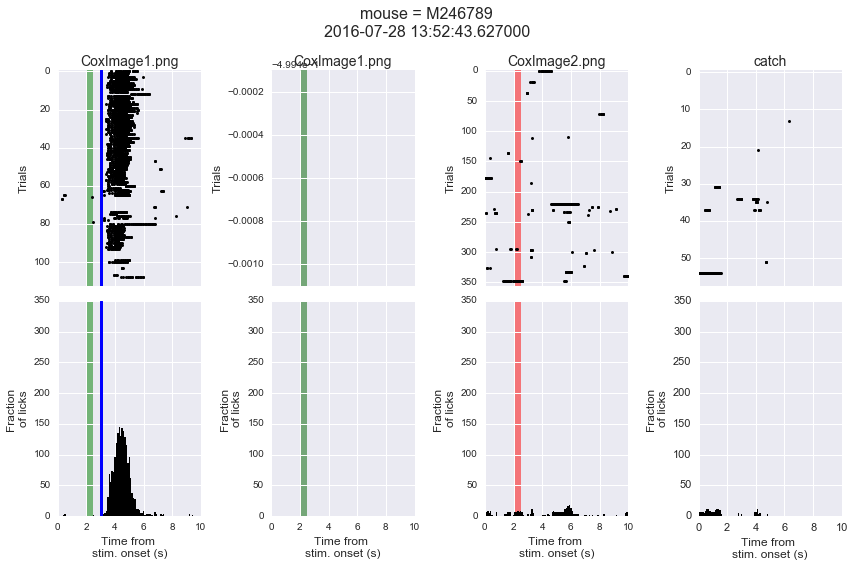

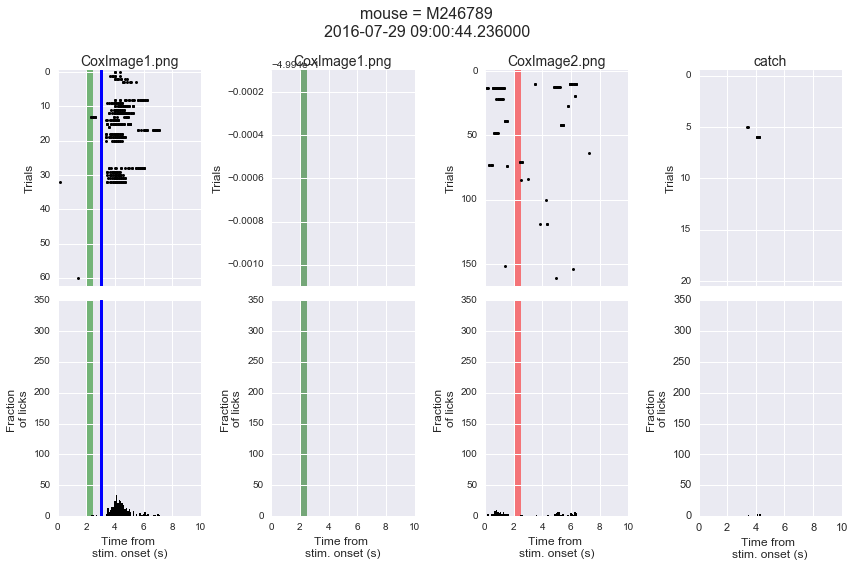

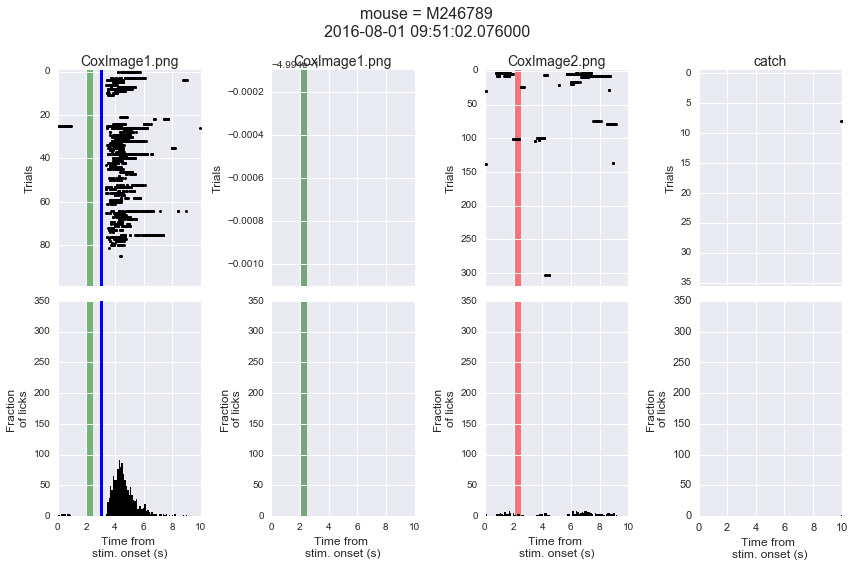

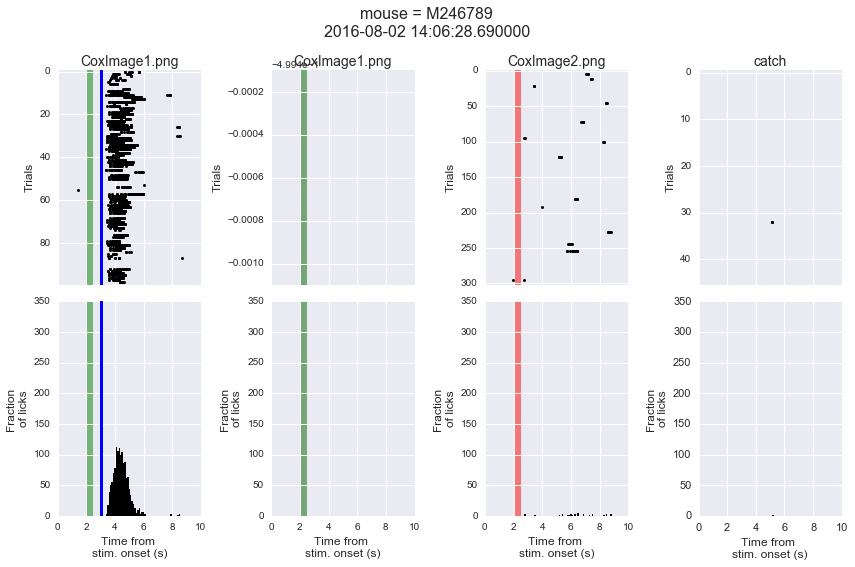

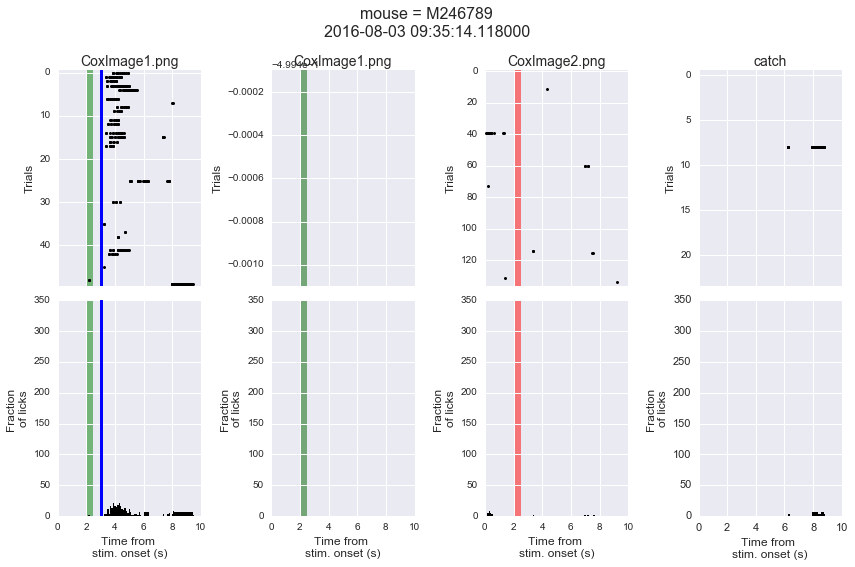

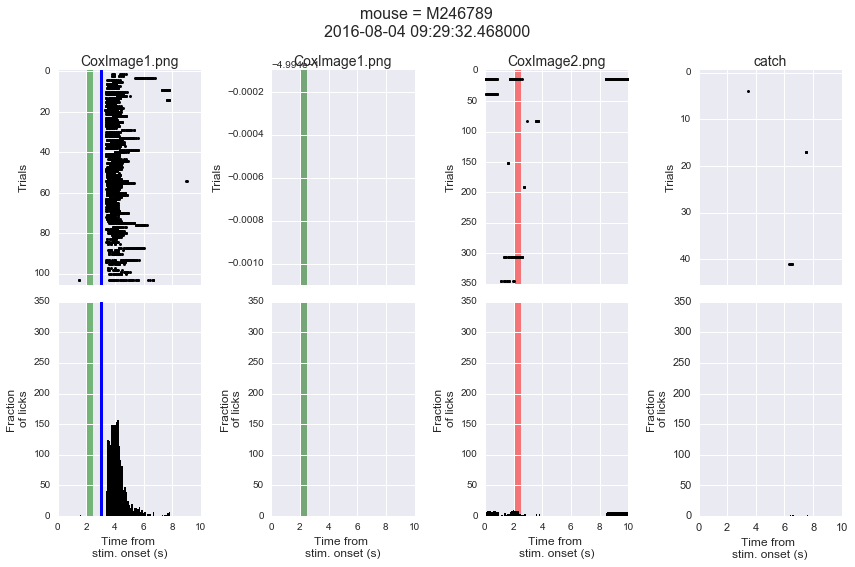

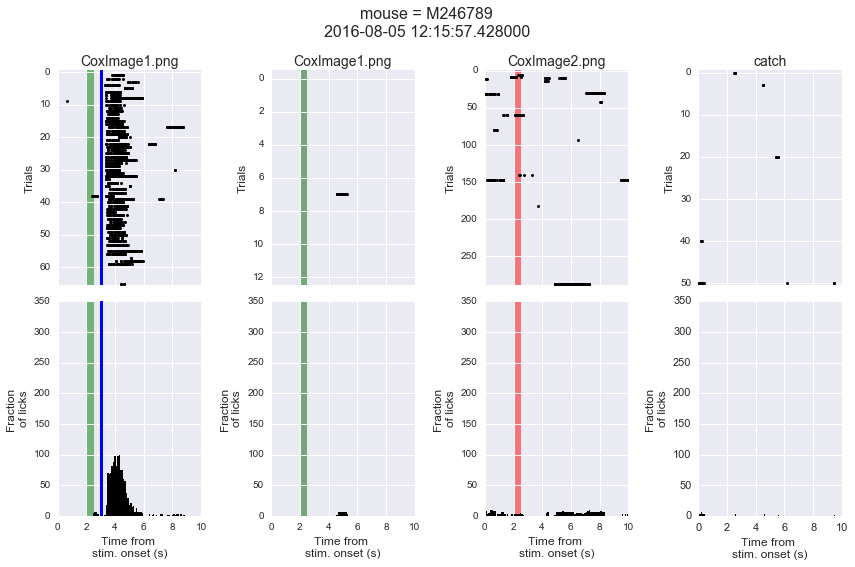

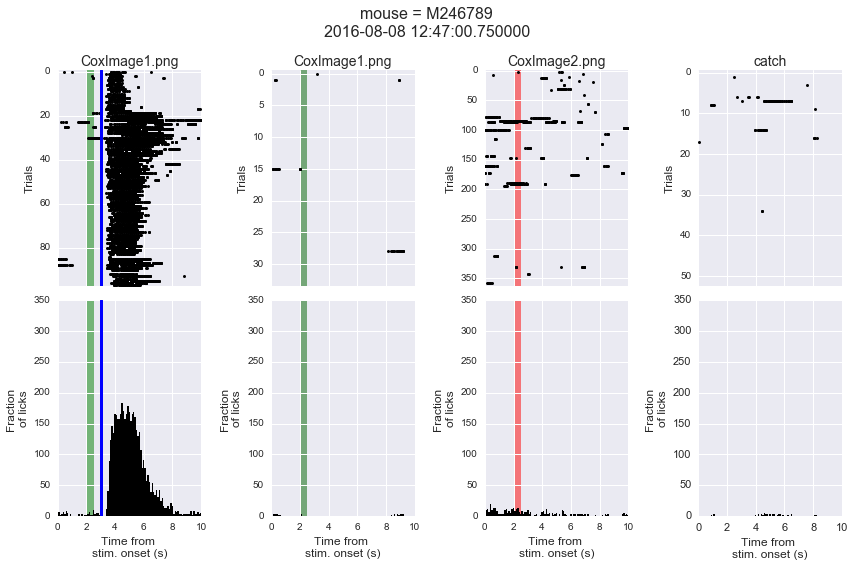

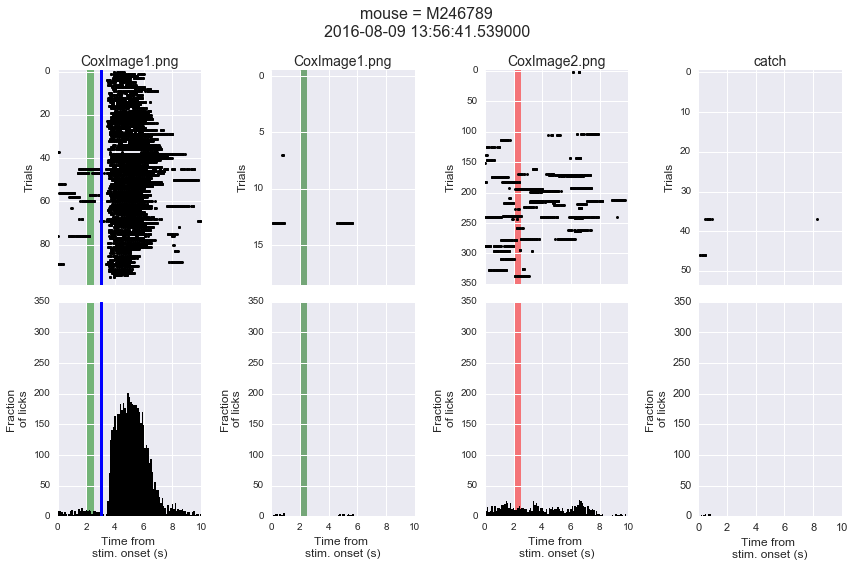

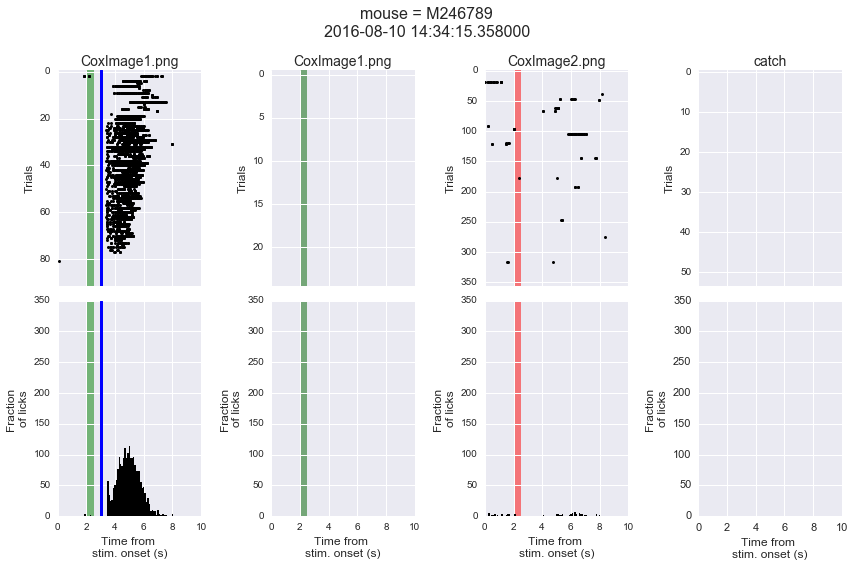

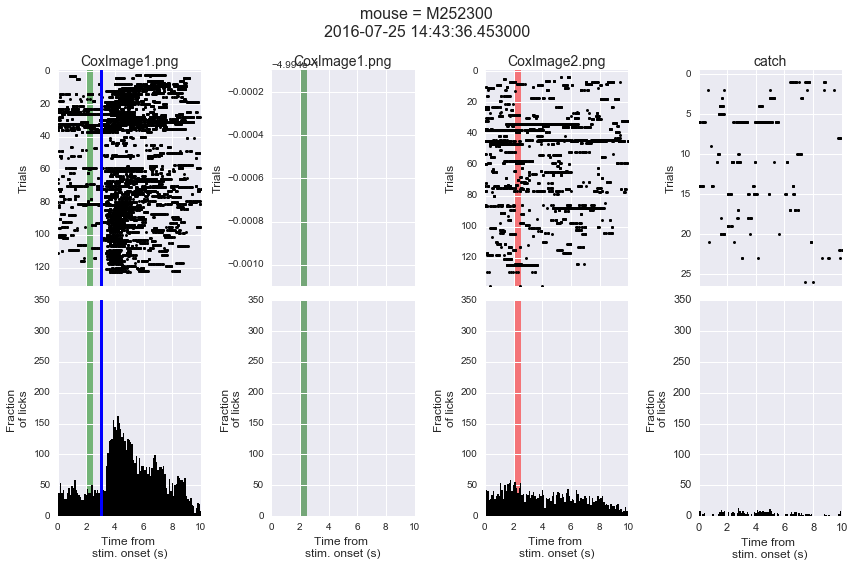

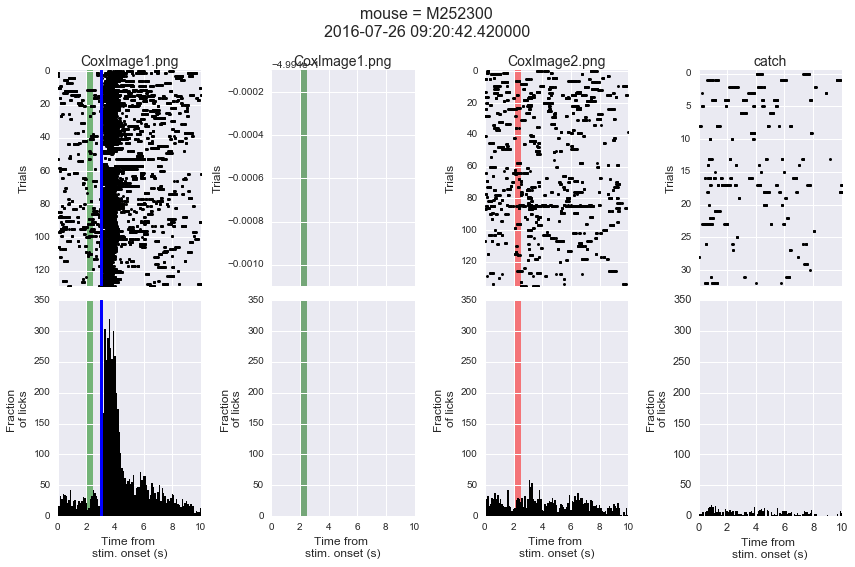

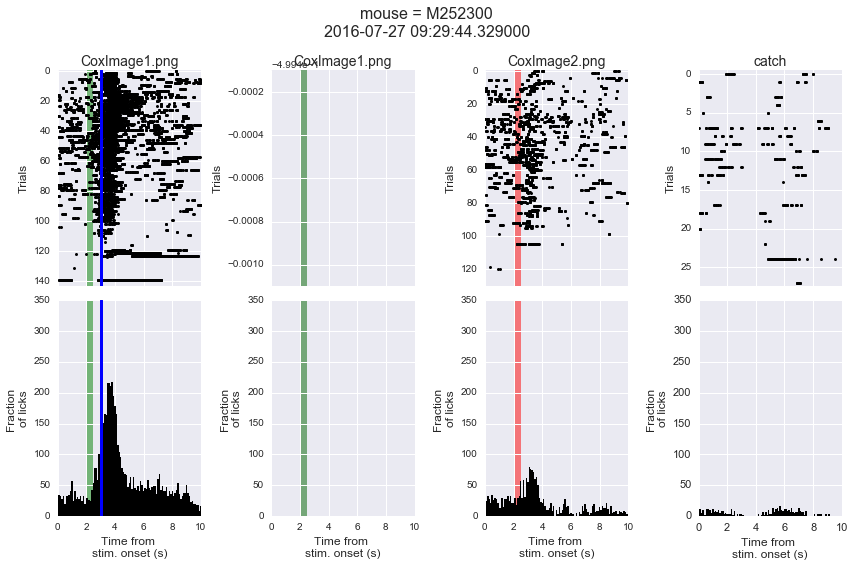

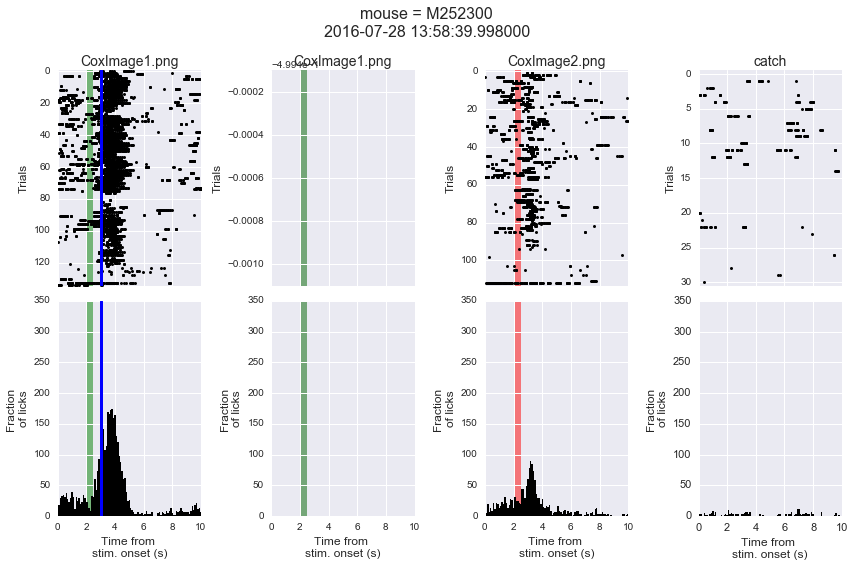

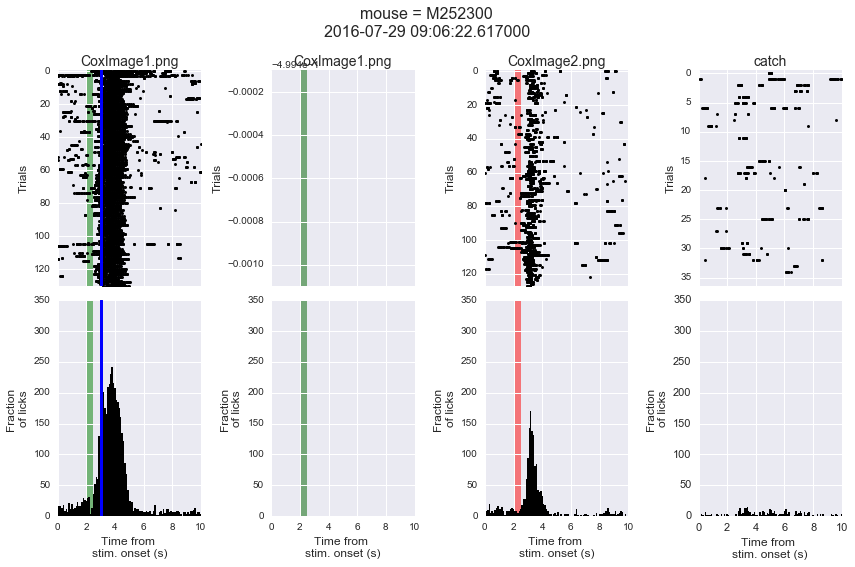

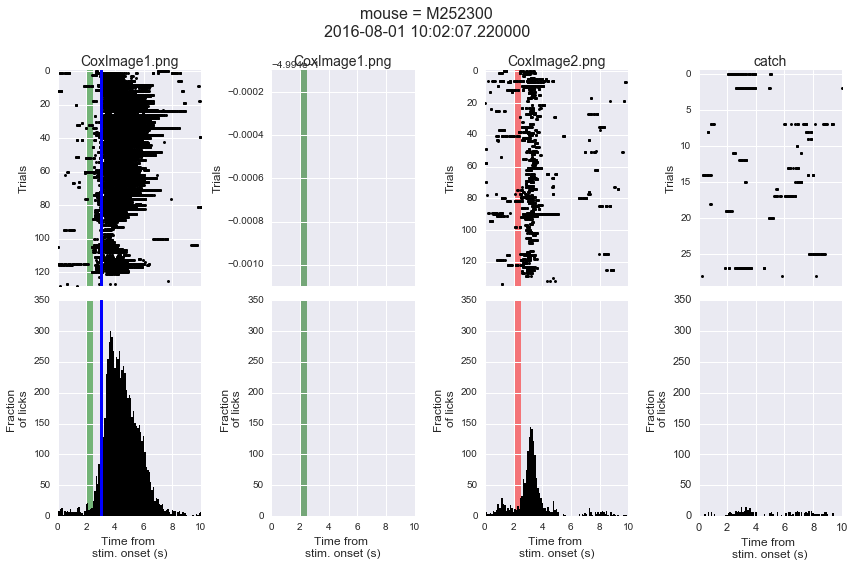

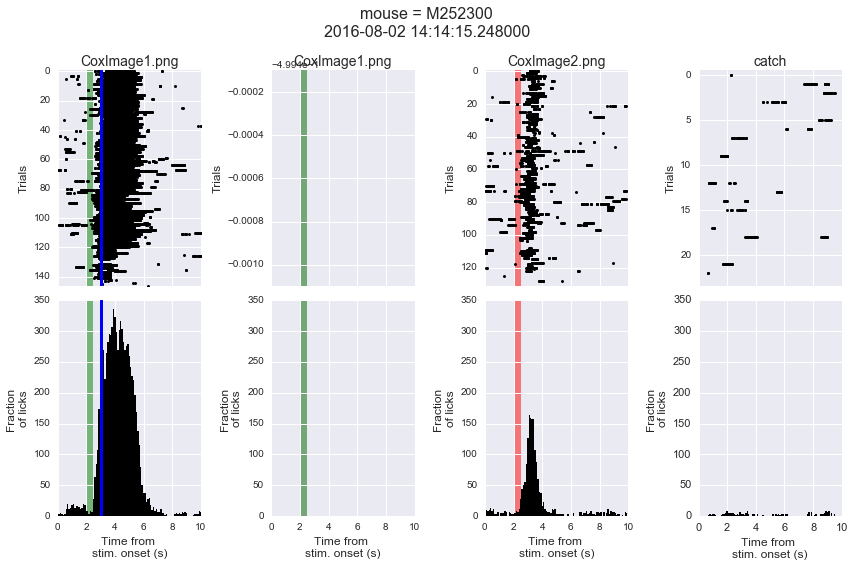

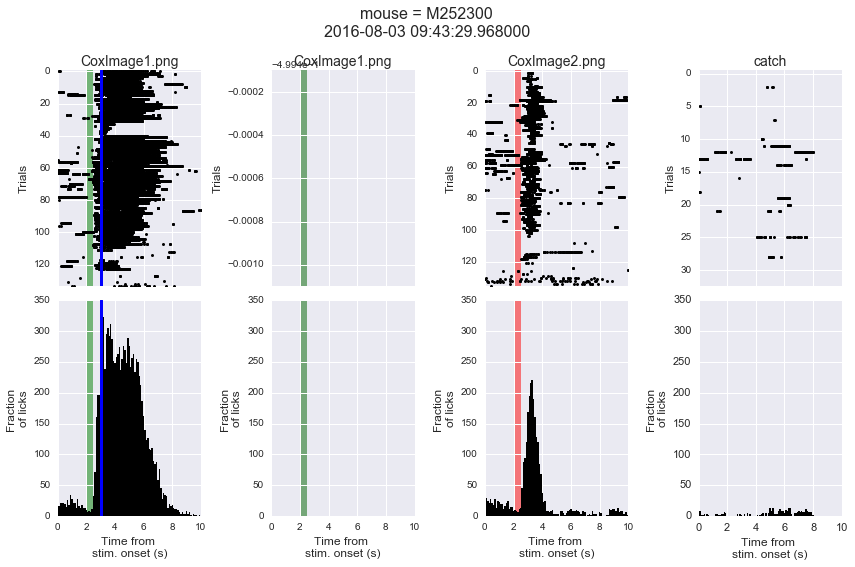

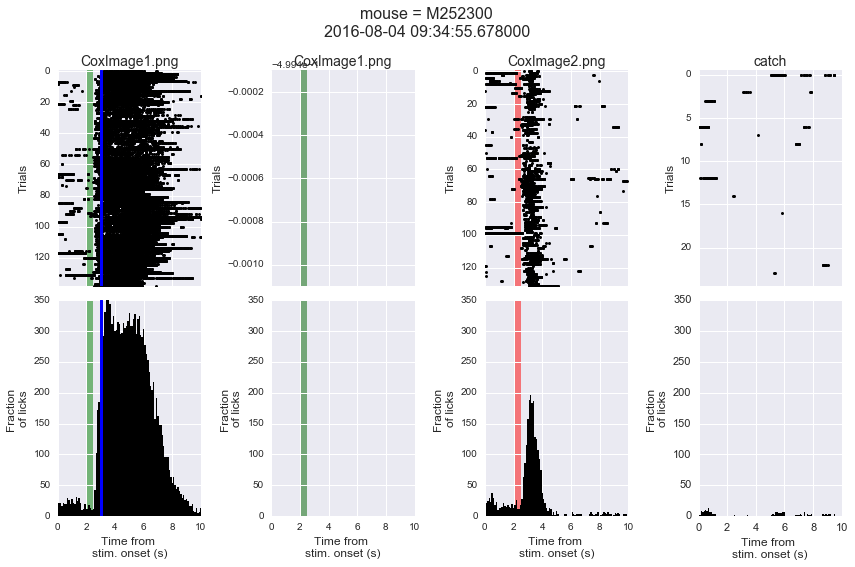

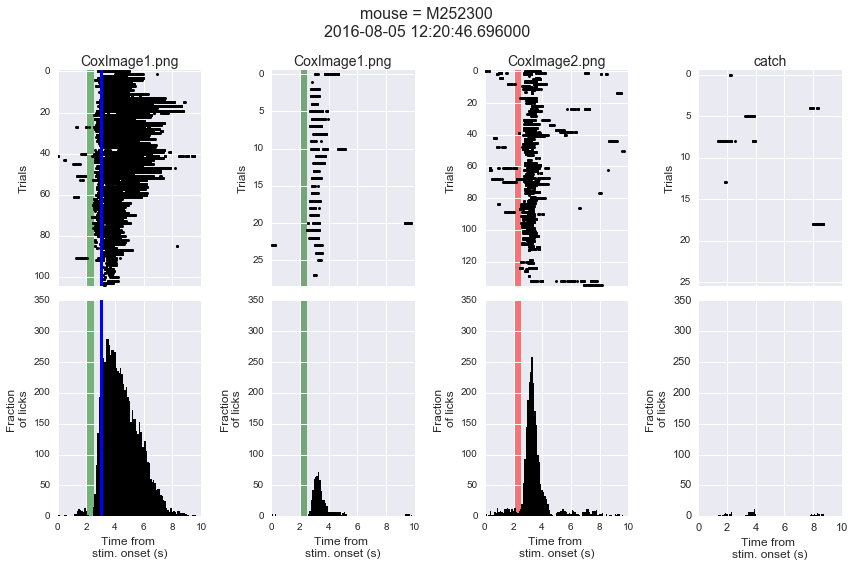

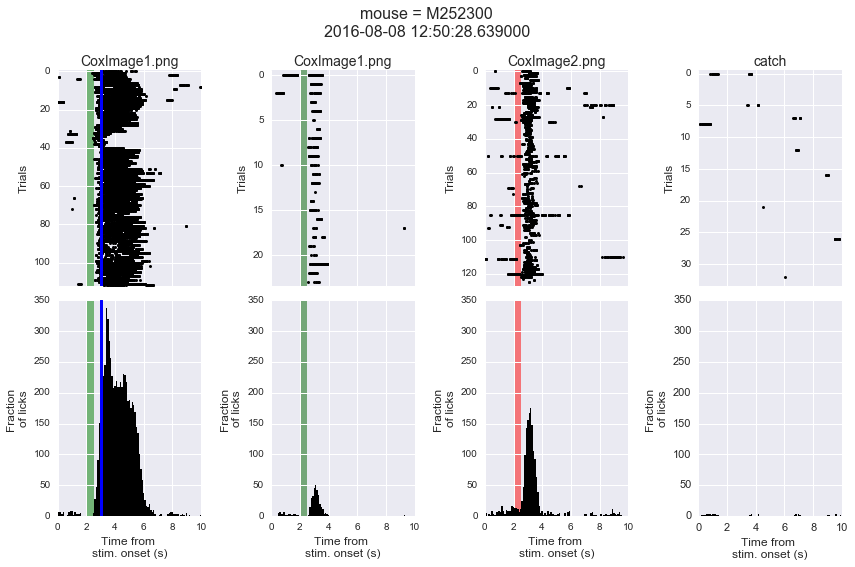

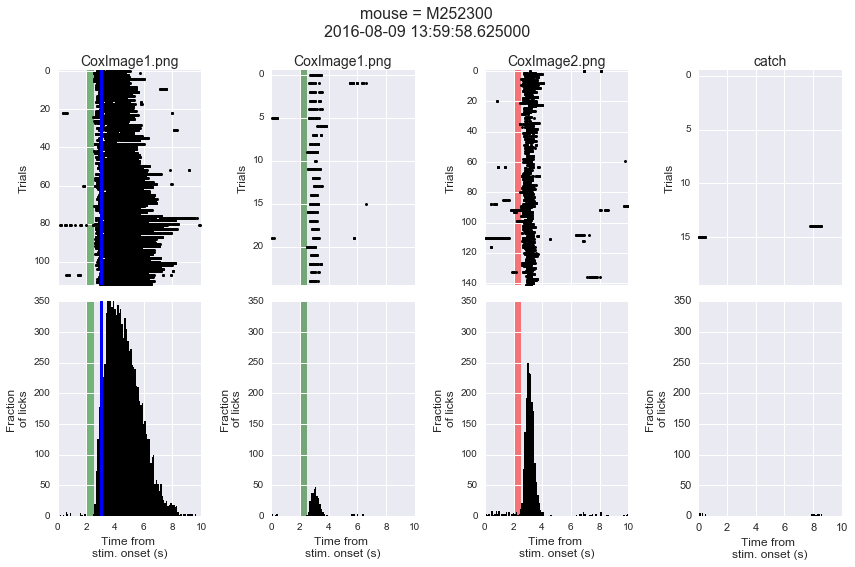

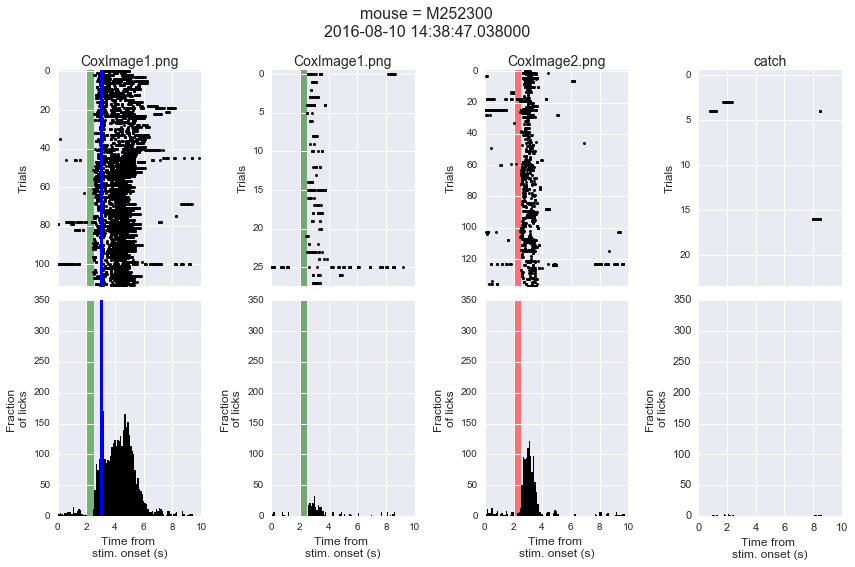

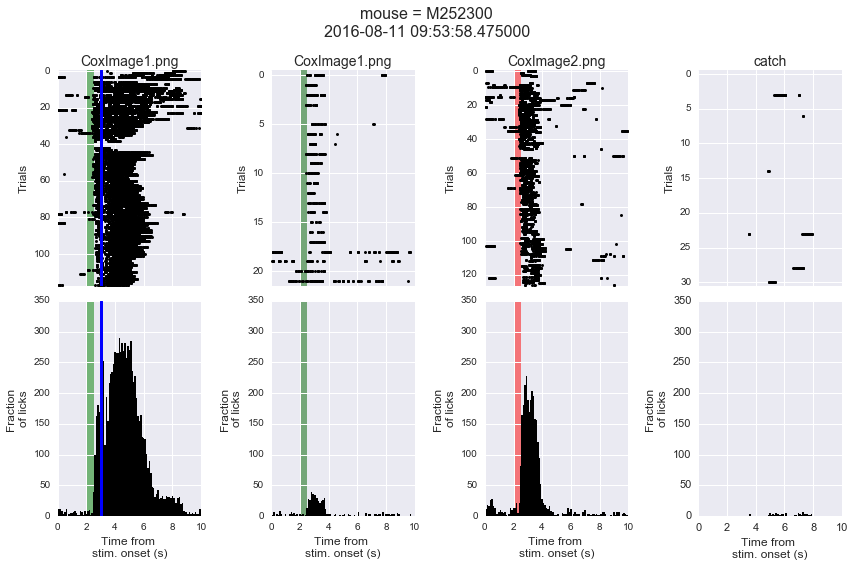

In [22]:
for mouse in np.sort(mice[0:]):
    savedir = os.path.join('/Users/dougo/Dropbox/PythonCode/Behavior/AssociativeLearningPilot',mouse,'figures')

    if os.path.exists(savedir)==False:
        os.mkdir(savedir)
        
    for startdatetime in df[(df.mouse_id == mouse)].startdatetime.unique():
        
        fig,ax=plt.subplots(2,4,figsize=(12,8))

        all_data[mouse][startdatetime]['pre_licks']={}
        all_data[mouse][startdatetime]['post_licks']={}
        all_data[mouse][startdatetime]['Post/Pre']={}
        all_data[mouse][startdatetime]['first_lick_mean']={}

        stimuli = ['CoxImage1.png', 'CoxImage1.png', 'CoxImage2.png', 'catch']
        rewarded = [True,False,False,False]
        span_colors = ['green','green','red','']
        span_colors = ['green','darkgreen','red',None]
        line_colors = ['green','darkgreen','red','black']

        for ii,stim_id in enumerate(stimuli):

            dft = df[(df.stimulus_id == stim_id) & 
                     (df.mouse_id == mouse) & 
                     (df.startdatetime==startdatetime) &
                     (df.rewarded==rewarded[ii])]

            #get lick times registered to trial start
            lick_times = get_local_event_times(dft[dft.stimulus_id == stim_id],'lick_times')

            #plot lick raster
            pf.plotLickRaster(lick_times,ax=ax[0,ii],splitLicksOnReward=False,
                              plotPostRewardLicks=True,
                              showXLabel=False,showYLabel=True,showYTicks=True,
                              postlickcolor='blue',fontsize=12,stimulus_delay=2,
                              leftlim=0,rightlim=10,
                              span_color=span_colors[ii],span_width=0.5)

            #plot lick histogram
            pf.plotLickPSTH(lick_times,ax=ax[1,ii],splitLicksOnReward=False,
                            plotPostRewardLicks=True,
                            showXLabel=True,showYLabel=True,showYTicks=True,
                            normalize_y=False,ylim=350,
                            postlickcolor='blue',fontsize=12,stimulus_delay=2,
                            leftlim=0,rightlim=10,
                            span_color=span_colors[ii],span_width=0.5)

            #plot vertical line for rewards
            if ii == 0:
                for row in range(2):
                    ax[row,0].axvline(3,color='blue',linewidth=3)

            ax[0,ii].set_title(stim_id,fontsize=14)

#                 pre_licks,post_licks,first_lick_mean = get_metrics(dft)

#                 all_data[mouse][startdatetime]['pre_licks'][stim_id]=pre_licks
#                 all_data[mouse][startdatetime]['post_licks'][stim_id]=post_licks
#                 try:
#                     all_data[mouse][startdatetime]['Post/Pre'][stim_id]=post_licks/pre_licks
#                 except:
#                     all_data[mouse][startdatetime]['Post/Pre'][stim_id]=np.nan
#                 all_data[mouse][startdatetime]['first_lick_mean'][stim_id]=first_lick_mean

        fig.tight_layout()
        plt.subplots_adjust(top=0.87)
        fig.suptitle('mouse = '+mouse+'\n'+startdatetime,fontsize=16)

        fig.savefig(os.path.join(savedir,startdatetime.split(" ")[0]+'.png'))


In [23]:
dft

lick_times  ori response_latency  \
3872                                                 []    0             None   
3875                                                 []    0             None   
3878                                                 []    0             None   
3907  [340.416552573, 340.435674984, 340.535672192, ...    0             None   
3920                                                 []    0             None   
3925                                                 []    0             None   
3926                     [499.267610151, 499.284242198]    0             None   
3929                                                 []    0             None   
3931                                                 []    0             None   
3935                                                 []    0             None   
3938                                                 []    0             None   
3960                                                 []    0             None   
3972                                                 []    0             None   
3977                                                 []    0             None   
3978       [974.835689157, 974.85244019, 974.869186409]    0             None   
3986                                                 []    0             None   
3997                                                 []    0             None   
4004                                                 []    0             None   
4008                                                 []    0             None   
4009                                                 []    0             None   
4013                                                 []    0             None   
4043                                                 []    0             None   
4053                                                 []    0             None   
4096  [2045.19007818, 2045.2067006, 2045.22332656, 2...    0             None   
4115                                                 []    0             None   
4125                                                 []    0             None   
4131                                                 []    0             None   
4141                                                 []    0             None   
4142  [2464.54422506, 2464.56097481, 2464.69484483, ...    0             None   
4145                                                 []    0             None   
4146  [2499.27411877, 2499.29074312, 2499.30736811, ...    0             None   

     response_time response_type reward_frames reward_times rewarded  size  \
3872            []            []            []           []    False    50   
3875            []            []            []           []    False    50   
3878            []            []            []           []    False    50   
3907            []            []            []           []    False    50   
3920            []            []            []           []    False    50   
3925            []            []            []           []    False    50   
3926            []            []            []           []    False    50   
3929            []            []            []           []    False    50   
3931            []            []            []           []    False    50   
3935            []            []            []           []    False    50   
3938            []            []            []           []    False    50   
3960            []            []            []           []    False    50   
3972            []            []            []           []    False    50   
3977            []            []            []           []    False    50   
3978            []            []            []           []    False    50   
3986            []            []            []           []    False    50   
3997            []            []            []           []    False    50   
4004            []            []            []  

In [24]:
d = pd.to_datetime(startdatetime)
print d.month,d.day,d.dayofyear

8 11 224


2016-08-05 12:17:59.027000
2016-08-08 12:49:16.881000
2016-08-09 14:02:33.131000
2016-08-10 14:37:30.245000
2016-08-11 09:52:57.769000
2016-08-05 12:15:43.463000
2016-08-08 12:45:11.923000
2016-08-09 13:55:26.554000
2016-08-10 14:35:39.280000
2016-08-05 12:19:43.759000
2016-08-08 12:48:11.546000
2016-08-09 14:01:11.528000
2016-08-10 14:41:03.518000
2016-08-11 09:50:12.548000
2016-08-05 12:15:57.428000
2016-08-08 12:47:00.750000
2016-08-09 13:56:41.539000
2016-08-10 14:34:15.358000
2016-08-05 12:20:46.696000
2016-08-08 12:50:28.639000
2016-08-09 13:59:58.625000
2016-08-10 14:38:47.038000
2016-08-11 09:53:58.475000


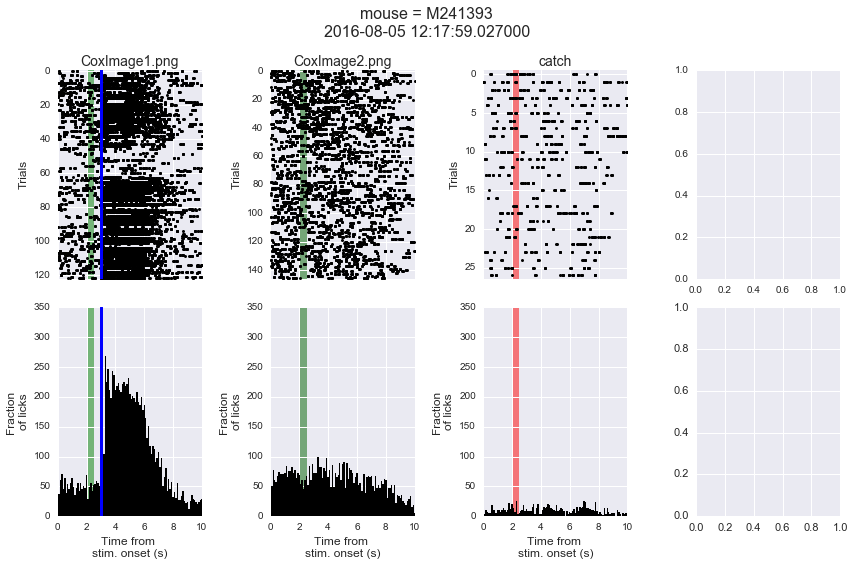

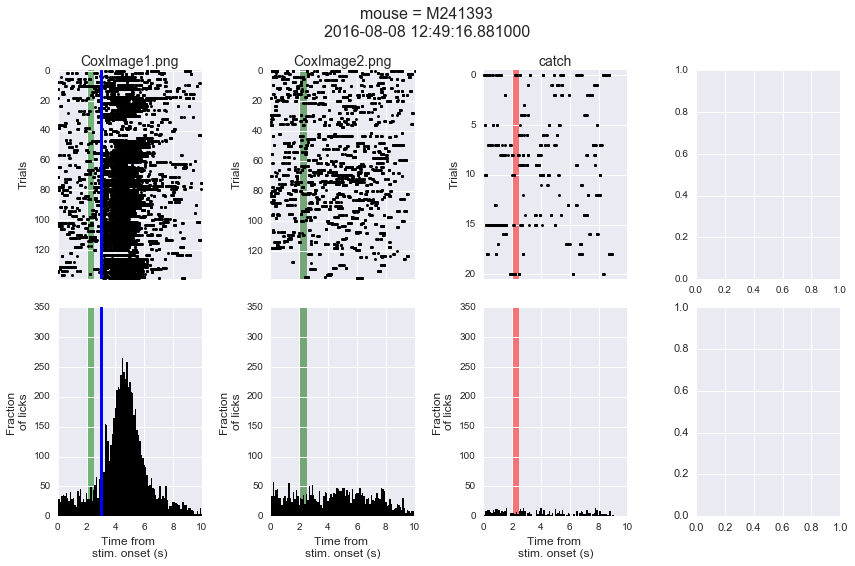

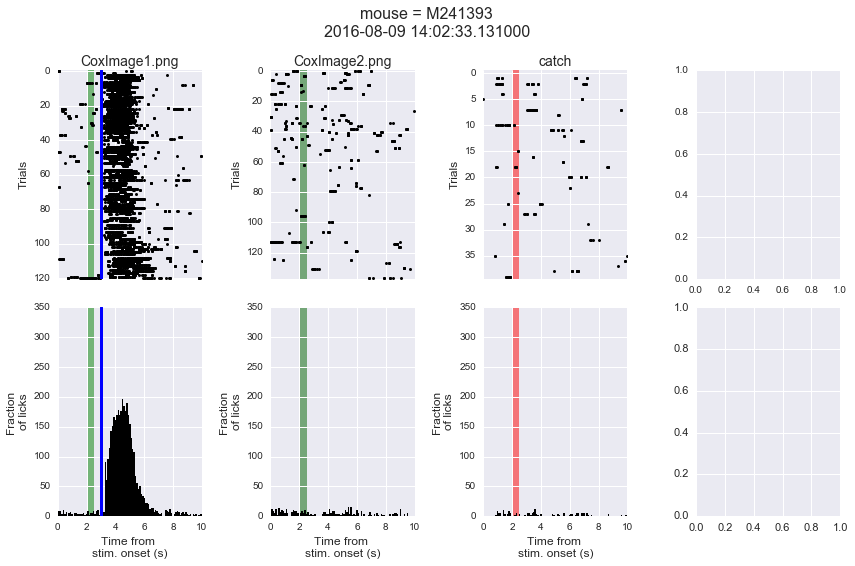

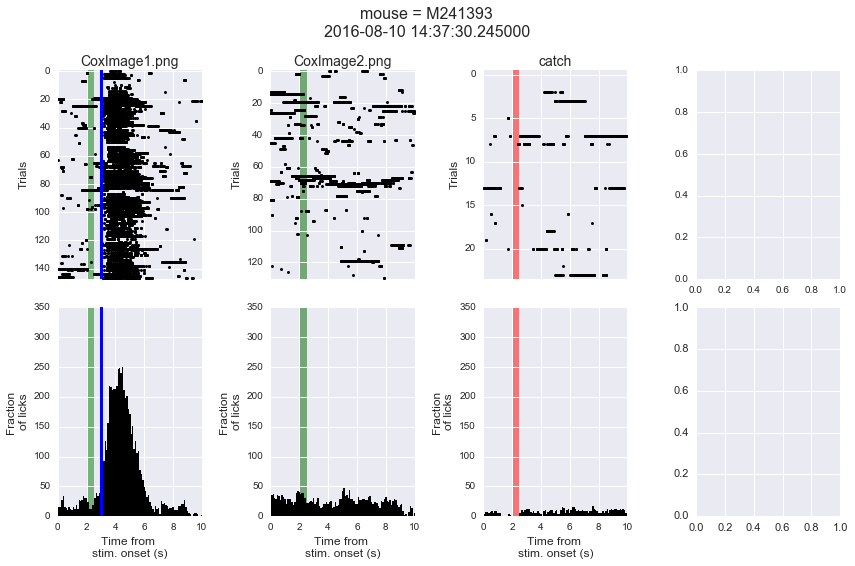

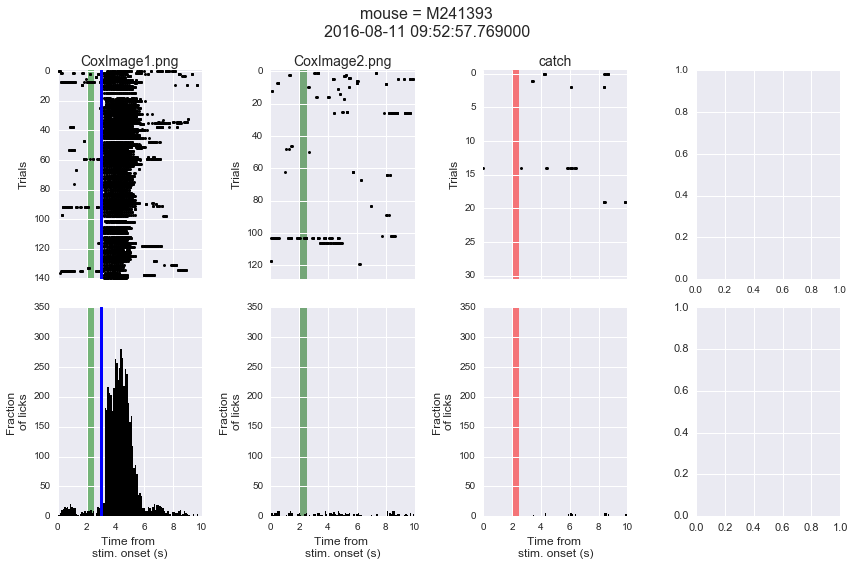

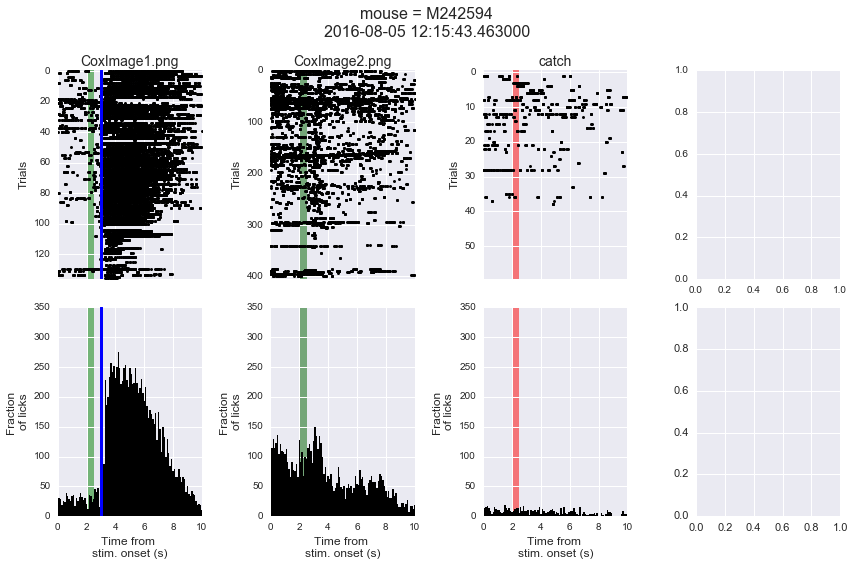

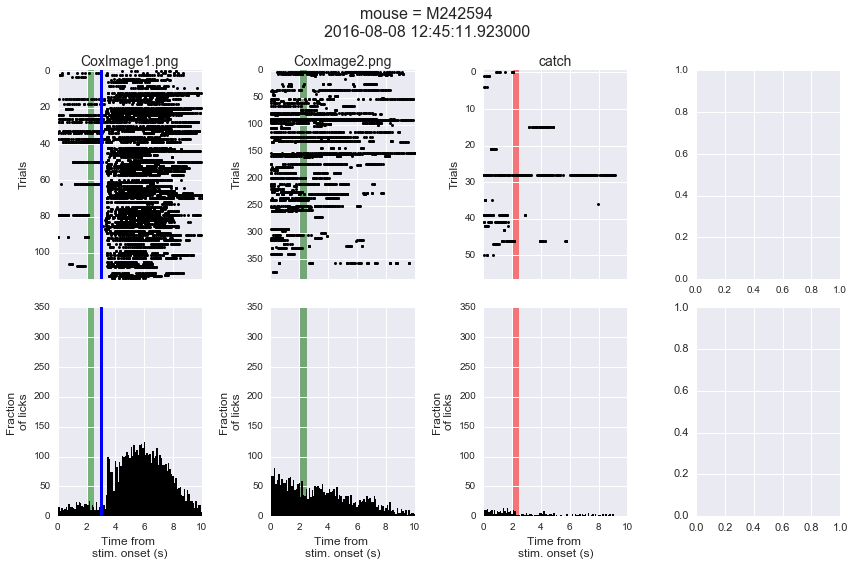

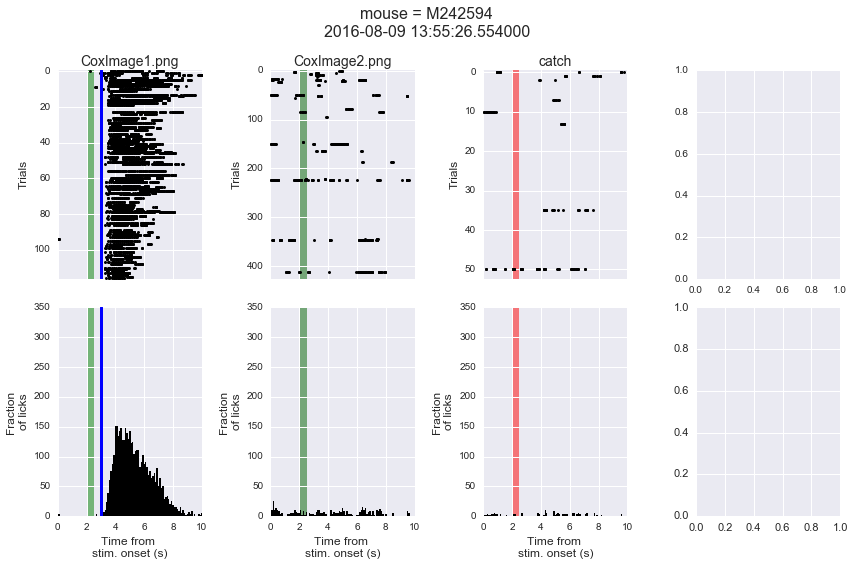

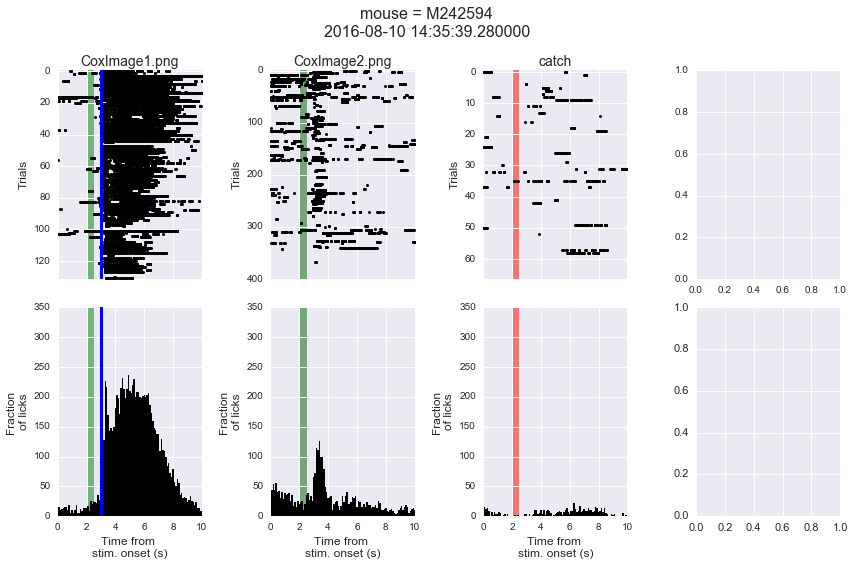

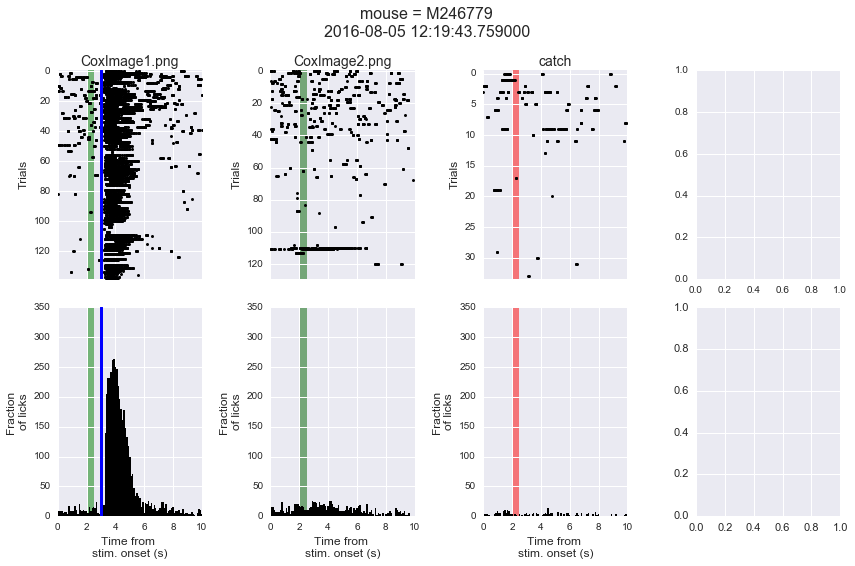

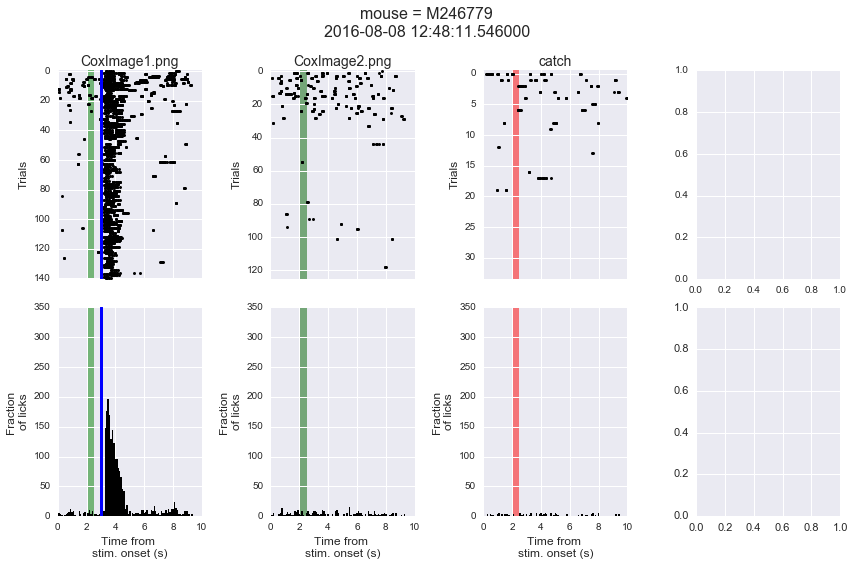

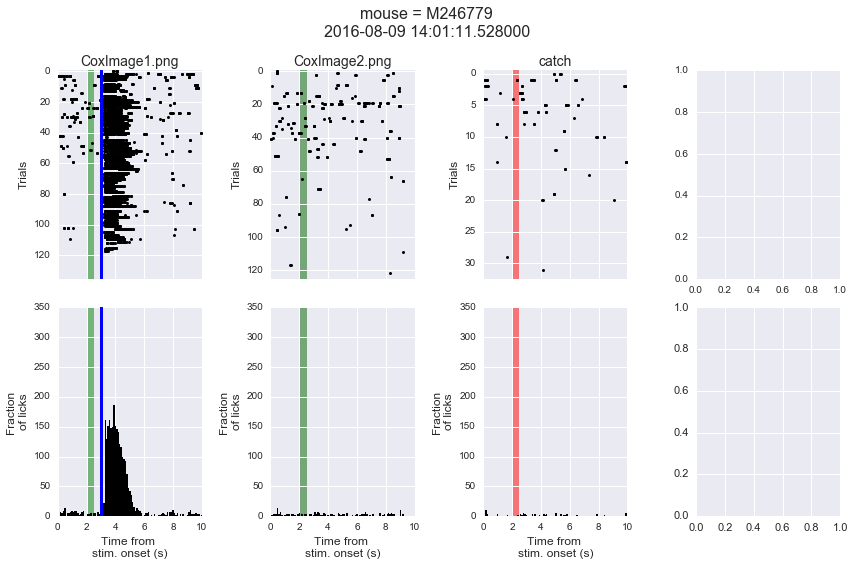

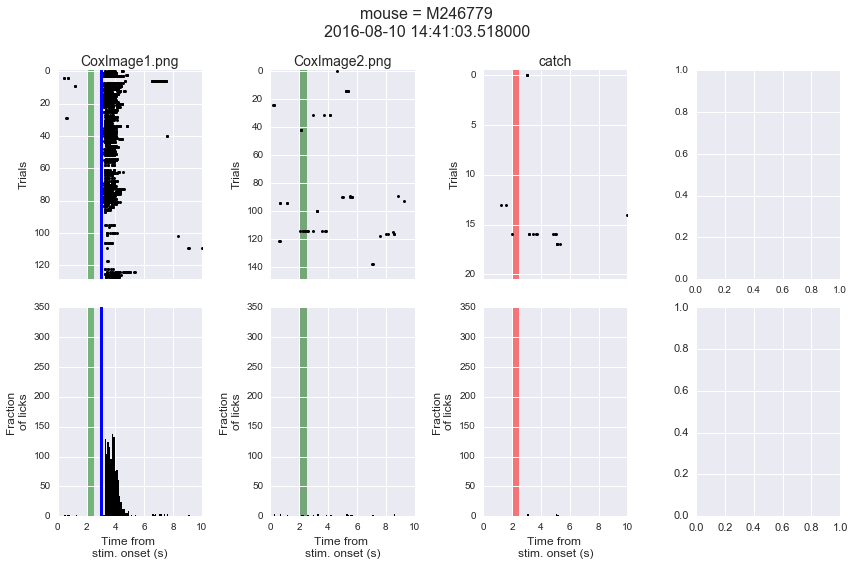

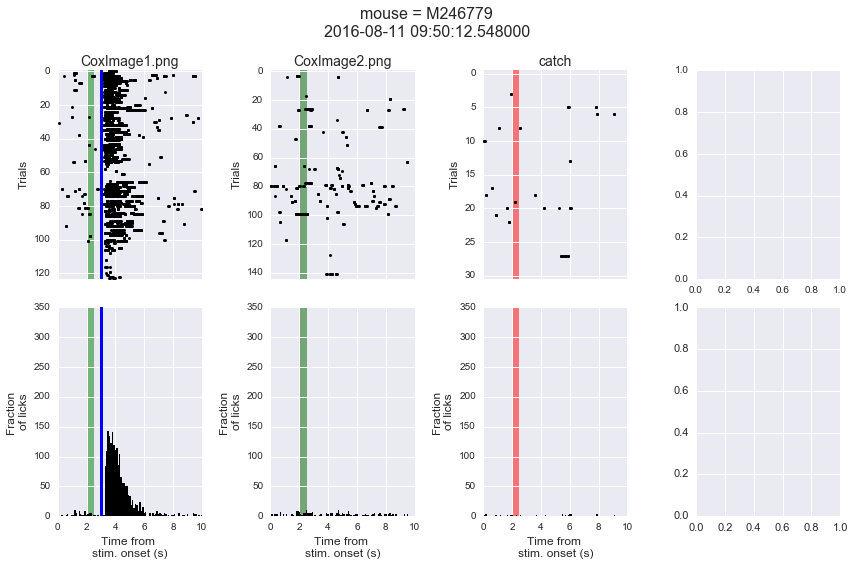

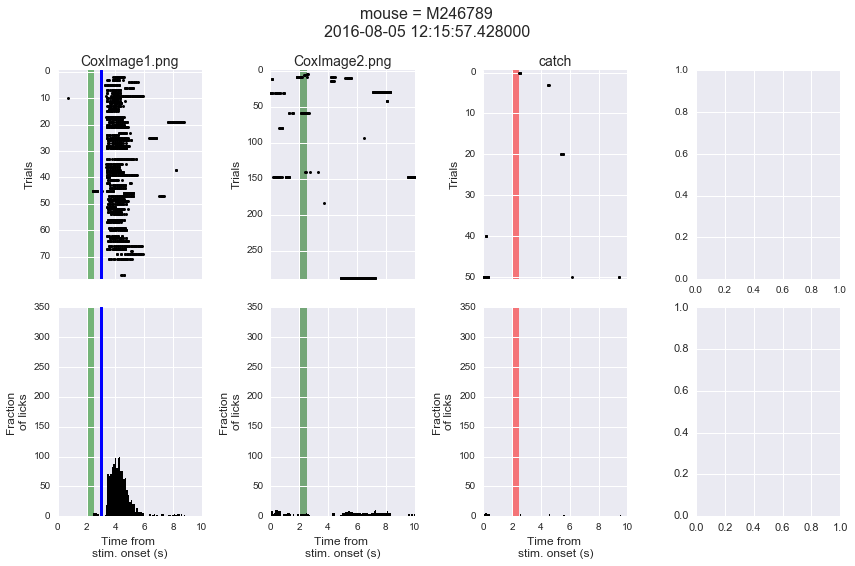

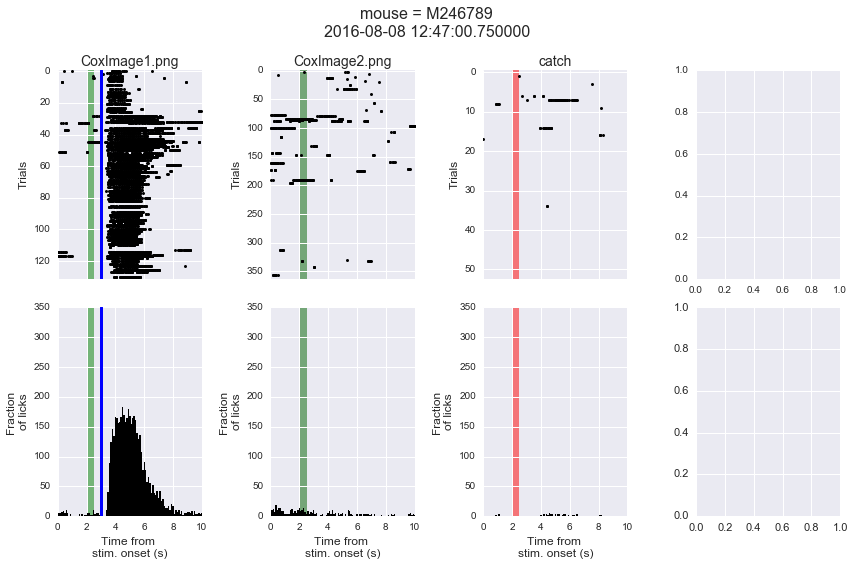

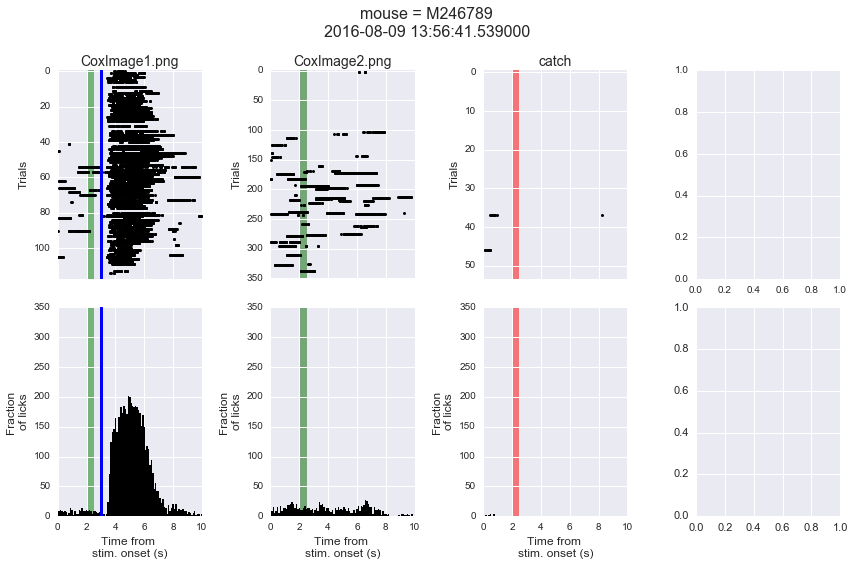

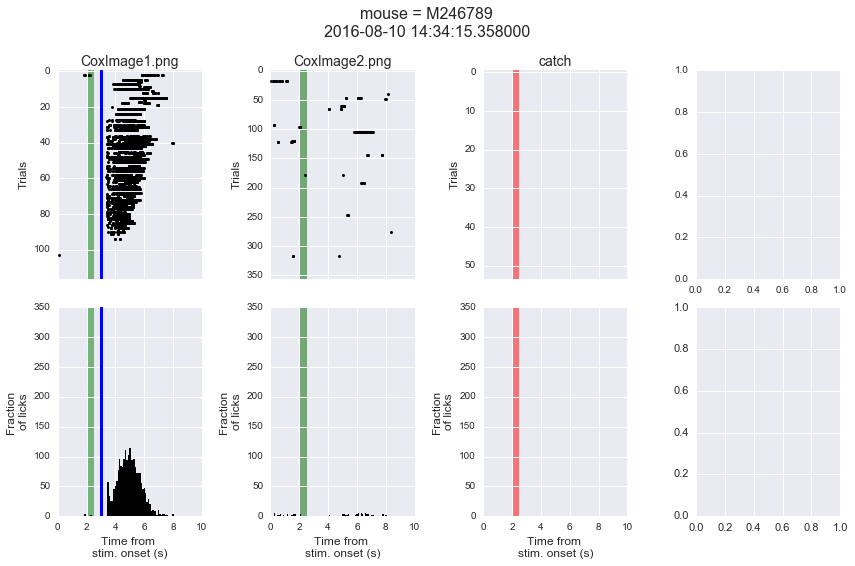

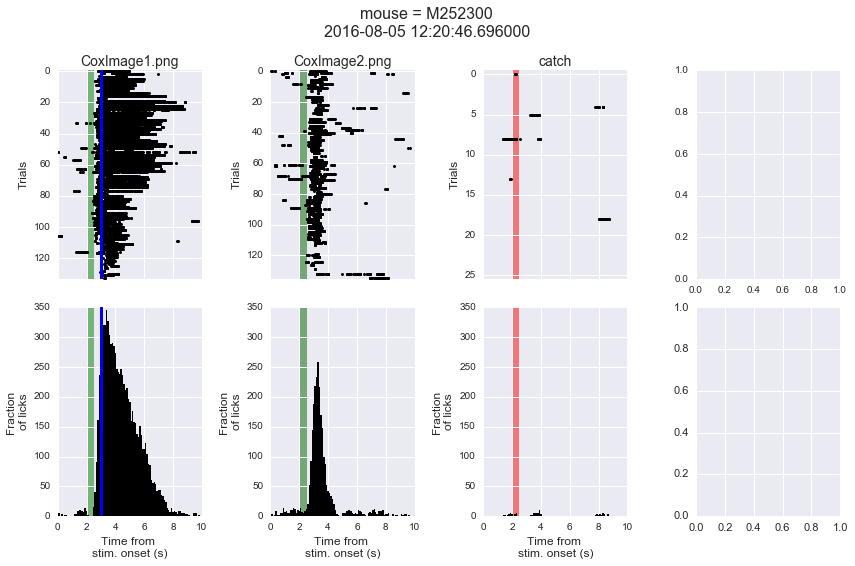

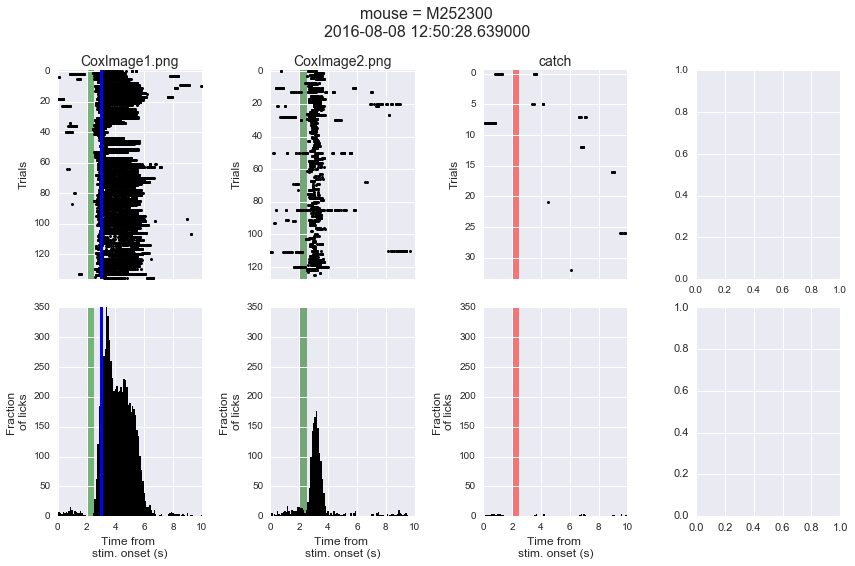

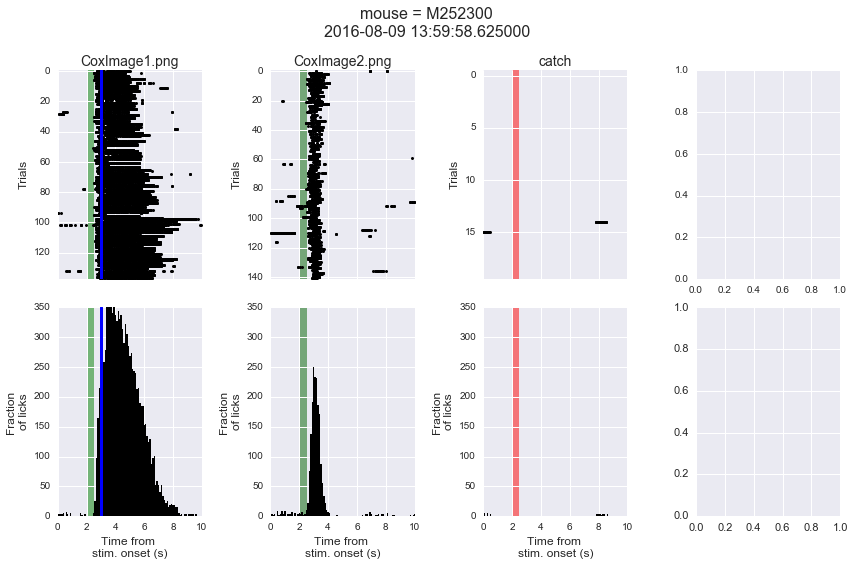

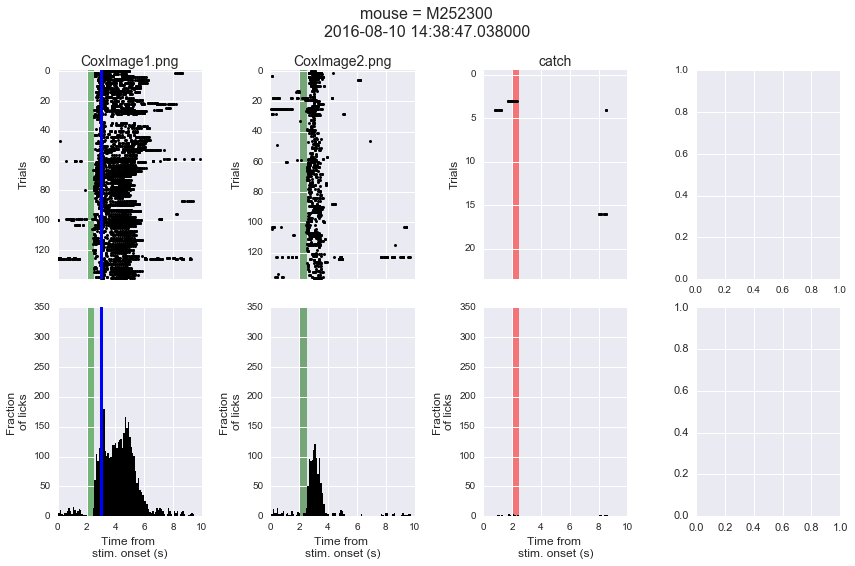

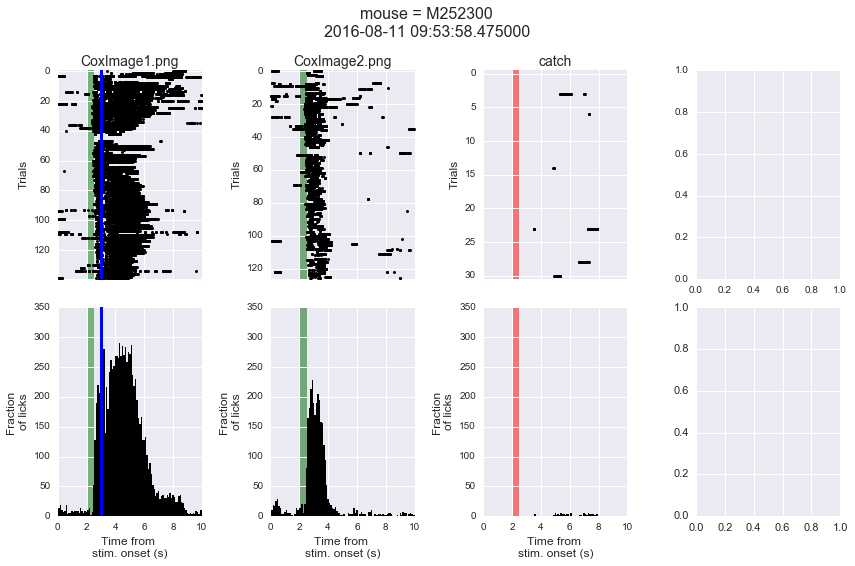

In [25]:
for mouse in np.sort(mice[0:]):
    savedir = os.path.join('/Users/dougo/Dropbox/PythonCode/Behavior/AssociativeLearningPilot',mouse,'figures')

    if os.path.exists(savedir)==False:
        os.mkdir(savedir)
        
    for startdatetime in df[(df.mouse_id == mouse)].startdatetime.unique():
        d = pd.to_datetime(startdatetime)
        if d.dayofyear >= 218:
            print startdatetime
            
            try:
                fig,ax=plt.subplots(2,4,figsize=(12,8))

#                 all_data[mouse][startdatetime]['pre_licks']={}
#                 all_data[mouse][startdatetime]['post_licks']={}
#                 all_data[mouse][startdatetime]['Post/Pre']={}
#                 all_data[mouse][startdatetime]['first_lick_mean']={}

    
                for ii,stim_id in enumerate(np.sort(df.stimulus_id.unique())):
                    dft = df[(df.stimulus_id == stim_id) & (df.mouse_id == mouse) & (df.startdatetime==startdatetime)]
                    #get lick times registered to trial start
                    lick_times = get_local_event_times(dft[dft.stimulus_id == stim_id],'lick_times')

                    #plot lick raster
                    pf.plotLickRaster(lick_times,ax=ax[0,ii],splitLicksOnReward=False,
                                      plotPostRewardLicks=True,
                                      showXLabel=False,showYLabel=True,showYTicks=True,
                                      postlickcolor='blue',fontsize=12,stimulus_delay=2,
                                      leftlim=0,rightlim=10,
                                      span_color=span_colors[ii],span_width=0.5)

                    #plot lick histogram
                    pf.plotLickPSTH(lick_times,ax=ax[1,ii],splitLicksOnReward=False,
                                    plotPostRewardLicks=True,
                                    showXLabel=True,showYLabel=True,showYTicks=True,
                                    normalize_y=False,ylim=350,
                                    postlickcolor='blue',fontsize=12,stimulus_delay=2,
                                    leftlim=0,rightlim=10,
                                    span_color=span_colors[ii],span_width=0.5)

                    #plot vertical line for rewards
                    if ii == 0:
                        for row in range(2):
                            ax[row,0].axvline(3,color='blue',linewidth=3)

                    ax[0,ii].set_title(stim_id,fontsize=14)

                    pre_licks,post_licks,first_lick_mean = get_metrics(dft)

                    all_data[mouse][startdatetime]['pre_licks'][stim_id]=pre_licks
                    all_data[mouse][startdatetime]['post_licks'][stim_id]=post_licks
                    try:
                        all_data[mouse][startdatetime]['Post/Pre'][stim_id]=post_licks/pre_licks
                    except:
                        all_data[mouse][startdatetime]['Post/Pre'][stim_id]=np.nan
                    all_data[mouse][startdatetime]['first_lick_mean'][stim_id]=first_lick_mean

                fig.tight_layout()
                plt.subplots_adjust(top=0.87)
                fig.suptitle('mouse = '+mouse+'\n'+startdatetime,fontsize=16)

                fig.savefig(os.path.join(savedir,startdatetime.split(" ")[0]+'.png'))
            except Exception as e:
                print "failed on",mouse,startdatetime
                print e
                print ""

## Definitions
first_lick = time to first lick after stim, but before water  

prestim_licks = number of licks before stimulus onsest  

poststim_licks = number of licks between stimulus and reward time

KeyError: 'CoxImage1.png'

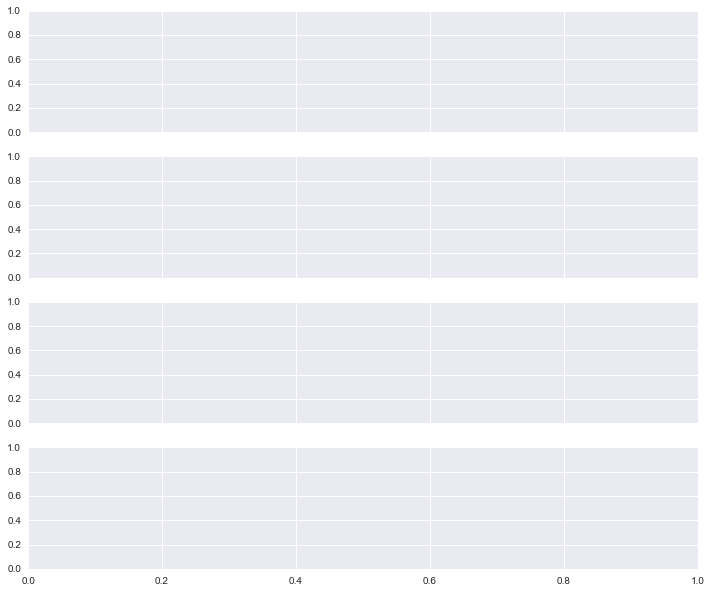

In [26]:
for mouse in np.sort(mice[0:]):
    fig,ax=plt.subplots(4,1,figsize=(12,10),sharex=True)
    for metric_index,metric in enumerate(['first_lick_mean','pre_licks','post_licks','Post/Pre']):
        vals = {}
        for stim_index,stim_id in enumerate(stimuli):
            vals[stim_id] = []
            for startdatetime in df[(df.mouse_id == mouse)].startdatetime.unique():

                vals[stim_id].append(all_data[mouse][startdatetime][metric][stim_id])
            ax[metric_index].plot(vals[stim_id],'o-',color=line_colors[stim_index])
        ax[metric_index].legend(stimuli,loc='best')
        ax[metric_index].set_title(metric)
        
    fig.tight_layout()
    plt.subplots_adjust(top=0.92)
    fig.suptitle('mouse = '+mouse,fontsize=16)

In [ ]:
colors = sns.color_palette("hsv", 6)
sns.palplot(colors)

In [ ]:
# G0 = 50/50
# G1 = 25/75

pre_licks = [[],[]]
dot_colors = [[],[]]
for ii,mouse in enumerate(np.sort(mice)):
    dates = np.sort(all_data[mouse].keys())
    last_day = dates[-1]
    stim_prob = all_data[mouse][last_day]['stimulus_probability']
    if stim_prob[0] == 0.5:
        g = 0
    else:
        g= 1
    for stim_id in stimuli:
        pre_licks[g].append(all_data[mouse][last_day]['pre_licks'][stim_id])
        dot_colors[g].append(colors[ii])

In [ ]:
fig,ax = plt.subplots()
for g in [0,1]:
    for ii,dot in enumerate(pre_licks[g]):
        ax.plot(g,dot,'o',color=dot_colors[g][ii])
    ax.errorbar(g*np.ones_like(pre_licks[g]),pre_licks[g],yerr=np.std(pre_licks[g]))
ax.plot([0,1],[np.mean(pre_licks[0]),np.mean(pre_licks[1])])
ax.set_xlim(-0.5,1.5)
ax.set_xticks([0,1])
ax.set_xticklabels(['50/50 group','25/75 group'])

In [ ]:
stats.ttest_rel(pre_licks[0],pre_licks[1])

In [ ]:
fig,ax=plt.subplots(figsize=(12,6))
for ii,mouse in enumerate(mice):
    ax.plot(0,ii,'o',color=colors[ii])
    ax.text(0.1,ii,mouse)
    ax.set_xlim(-0.1,0.25)

In [ ]:
stim_id = stimuli[2]
for stim_id in stimuli:
    print 'stimulus:',stim_id
    dft = df[(df.stimulus_id == stim_id) & (df.mouse_id == mouse) & (df.startdatetime==startdatetime)]
    lick_times = get_local_event_times(dft[dft.stimulus_id == stim_id],'lick_times')

    ntrials = len(dft)
    all_licks = ut.flatten_array(lick_times)

    print "number of trials:",ntrials
    print "number of licks:",len(all_licks)

    prestim_licks = all_licks[np.logical_and(all_licks>=1,all_licks<2)]
    print "number of prestimulus licks:",len(prestim_licks)
    print "number of prestim licks/trial/s",len(prestim_licks)/(1.0*ntrials)
    print ""
    poststim_licks = all_licks[np.logical_and(all_licks>=2,all_licks<3)]
    print "number of poststimulus licks:",len(poststim_licks)
    print "number of poststim licks/trial/s",len(poststim_licks)/(1.0*ntrials)
    print ""
    print ""

In [ ]:
all_data[mouse]['2016-07-27 09:29:44.329000']['stimulus_probability']

In [ ]:
vals = []
for i in range(100):
    val = np.random.rand(1)
    if val>0.5:
        vals.append(1)
    else:
        vals.append(0)

In [ ]:
fig,ax=plt.subplots()

ax.plot(np.arange(0,100),vals,'ok')